plot chromHMM

In [1]:
# python modules
import sys
import copy
import re
import random
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats


In [2]:
# custom modules
sys.path.append('/Users/sangwoopark/Projects/condense-seq/postpro_scripts')
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis


In [3]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"


In [4]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'E14':'mouse',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'E14':['chr%s' % (i) for i in range(1, 20)] + ['chrX', 'chrY'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}


In [5]:
agent_fullname = {'sp':'Spermine(4+)',
                  'spd':'Spermidine(3+)',
                  'CoH':'Cobalt Hexammine(3+)',
                  'PEG':'PEG 8000',
                  'HP1a':'HP1$\\alpha$',
                  'HP1bSUV':'HP1$\\beta$+tSUV',
                  'LKH':'Linker histone1',
                  'Ki67':'Ki67',
                  'FUS':'FUS',
                  'Mg':'Magnesium',
                  'Ca':'Calcium'}


In [6]:
## for H1
H1_name_dict = {"E1":"Polycomb repressed",
                "E2":"Poised promoter",
                "E3":"Weak promoter",
                "E4":"Strong enhancer",
                "E5":"Active promoter",
                "E6":"Weak enhancer",
                "E7":"Quiescence1",
                "E8":"Quiescence2",
                "E9":"Heterochromatin",
                "E10":"Tx elongation",
                "E11":"Weak Tx",
                "E12":"Insulator"}

# state for H1
H1_states = ["Active promoter", "Weak promoter", "Poised promoter", "Strong enhancer", "Weak enhancer", "Tx elongation", "Weak Tx", "Insulator", "Polycomb repressed", "Heterochromatin", "Quiescence1", "Quiescence2"]

H1_HMM_fname = "H1_12_segments.bed"


In [7]:
# for GM12878
GM_name_dict = {"E1":"Polycomb repressed",
                "E2":"Quiescence",
                "E3":"Heterochromatin",
                "E4":"Weak Tx",
                "E5":"Tx elongation",
                "E6":"Weak enhancer",
                "E7":"Active enhancer",
                "E8":"Strong enhancer",
                "E9":"Active promoter",
                "E10":"Weak promoter",
                "E11":"Poised promoter",
                "E12":"Insulator"}

# state for GM
GM_states = ["Active promoter", "Weak promoter", "Poised promoter", "Strong enhancer", "Active enhancer", "Weak enhancer", "Tx elongation", "Weak Tx", "Insulator", "Polycomb repressed", "Heterochromatin", "Quiescence"]

GM_HMM_fname = "GM12878_12_segments.bed"


In [8]:
# for mouse CD8 T cell
mCD8T_name_dict = {"E1":"Weak Tx",
                   "E2":"Tx elongation",
                   "E3":"Weak enhancer2",
                   "E4":"Strong enhancer2",
                   "E5":"Strong enhancer1",
                   "E6":"Weak enhancer1",
                   "E7":"Active promoter",
                   "E8":"Poised promoter",
                   "E9":"Polycomb repressed1",
                   "E10":"Polycomb repressed2",
                   "E11":"Quiescence",
                   "E12":"Heterochromatin"}

# state for mouse CD8 T cell
mCD8T_states = ["Active promoter", "Poised promoter", "Strong enhancer1", "Strong enhancer2", "Weak enhancer1", "Weak enhancer2", "Tx elongation", "Weak Tx", "Polycomb repressed1", "Polycomb repressed2", "Heterochromatin", "Quiescence"]

mCD8T_HMM_fname = "Mouse CD8 T cell (invitro activated)_12_segments.bed"


In [9]:
# for mouse E14 cell
E14_name_dict = {"E1":"Polycomb repressed",
                 "E2":"Quiescence",
                 "E3":"Heterochromatin",
                 "E4":"Weak Tx2",
                 "E5":"Tx elongation",
                 "E6":"Weak Tx1",
                 "E7":"Strong Tx",
                 "E8":"Weak promoter",
                 "E9":"Weak enhancer",
                 "E10":"Poised promoter2",
                 "E11":"Poised promoter1",
                 "E12":"Active promoter"}

# state for mouse E14 cell
E14_states = ["Active promoter",
              "Weak promoter",
              "Strong Tx",
              "Weak Tx1",
              "Weak Tx2",
              "Weak enhancer",
              "Poised promoter1",
              "Poised promoter2",
              "Tx elongation",
              "Polycomb repressed",
              "Heterochromatin",
              "Quiescence"]

E14_HMM_fname = "E14_12_segments.bed"

In [10]:
# data path
#path = './data/'
path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/'
chromHMM_path = '/Users/sangwoopark/jhu_rockfish/chromHMM_data/'

In [11]:
# chromHMM data set
cell_chromHMM = {'H1':[H1_HMM_fname, H1_name_dict, H1_states],
                 'GM':[GM_HMM_fname, GM_name_dict, GM_states],
                 'E14':[E14_HMM_fname, E14_name_dict, E14_states],
                 'mCD8T:WT':[mCD8T_HMM_fname, mCD8T_name_dict, mCD8T_states],
                 'mCD8T:DFMO':[mCD8T_HMM_fname, mCD8T_name_dict, mCD8T_states],
                 'mCD8T:ODCKO':[mCD8T_HMM_fname, mCD8T_name_dict, mCD8T_states]}


In [12]:
### set data information (fname/field) and key
path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/'

dinfo_dkey = {'E14_NCP_sp_1rep_10kb_score_table.gtab.gz':
              {'E14_NCP_sp_%d_1rep' % (i) :(1, 'NCP', 'score', i) for i in range(1, 10)},
              'E14_NCPre1_sp_1rep_10kb_score_table.gtab.gz':
              {'E14_NCPre1_sp_%d_1rep' % (i) :(1, 'NCPre1', 'score', i) for i in range(1, 10)},
              'E14_NCPre2_sp_1rep_10kb_score_table.gtab.gz':
              {'E14_NCPre2_sp_%d_1rep' % (i) :(1, 'NCPre2', 'score', i) for i in range(1, 10)},
              'E14_NCPre3_sp_1rep_10kb_score_table.gtab.gz':
              {'E14_NCPre3_sp_%d_1rep' % (i) :(1, 'NCPre3', 'score', i) for i in range(1, 10)},
              'E14_NCPre4_sp_1rep_10kb_score_table.gtab.gz':
              {'E14_NCPre4_sp_%d_1rep' % (i) :(1, 'NCPre4', 'score', i) for i in range(1, 10)},
              }

dinfo_dkey['E14_NCP_sp_1rep_10kb_score_table.gtab.gz']['ATcontent'] \
    = (1, 'NCP', 'ATcontent', 0)
dinfo_dkey['E14_NCPre1_sp_1rep_10kb_score_table.gtab.gz']['ATcontent'] \
    = (1, 'NCPre1', 'ATcontent', 0)

In [13]:
### load gtab file
dkey_chr_ID_value = {}
for fkey in dinfo_dkey:
    field_dkey = dinfo_dkey[fkey]
    for fname in glob.glob(path + '*'):
        if not re.match(fkey, fname.rsplit('/')[-1]):
            continue
        print "loading %s" % (fname.rsplit('/')[-1])
        field_chr_ID_value = load_file.read_gtab(fname,
                                                 mode='col',
                                                 field_choices=field_dkey.keys(),
                                                 by_chr=True)

        for field, dkey in field_dkey.items():
            chr_ID_value = field_chr_ID_value[field]

            if dkey not in dkey_chr_ID_value:
                dkey_chr_ID_value[dkey] = {}
            dkey_chr_ID_value[dkey].update(chr_ID_value)
        

loading E14_NCPre1_sp_1rep_10kb_score_table.gtab.gz


loading E14_NCPre2_sp_1rep_10kb_score_table.gtab.gz


loading E14_NCPre3_sp_1rep_10kb_score_table.gtab.gz


loading E14_NCP_sp_1rep_10kb_score_table.gtab.gz


loading E14_NCPre4_sp_1rep_10kb_score_table.gtab.gz


In [14]:
### loading the chromHMM data
cell_chr_state_intervals = {}
for cell in ['E14']:
    HMM_fname, name_dict, states = cell_chromHMM[cell]
    chr_state_intervals = load_file.read_chromHMM(chromHMM_path + HMM_fname,
                                                  state_name=name_dict,
                                                  chr_choices=cell_chrnames[cell])
    cell_chr_state_intervals[cell] = chr_state_intervals

In [15]:
### categorize by chromHMM
dkey_state_IDs = {}
for dkey in dkey_chr_ID_value:
    print dkey
    #cell = 'GM'
    cell = 'E14'
    chr_state_intervals = cell_chr_state_intervals[cell]
    chr_ID_value = dkey_chr_ID_value[dkey]
    state_IDs = {}
    for chr in chr_ID_value:
        ID_interval = {ID:ID[1:3] for ID in chr_ID_value[chr]}
        #state_IDs_temp = statis.categorize(chr_state_intervals[chr],
        #                                   ID_pos)
        state_IDs_temp = statis.categorize_rbin (chr_state_intervals[chr],
                                                 bin_size=10000,
                                                 bin_step=10000,
                                                 binID_interval=ID_interval,
                                                 silent=True)
        for state in state_IDs_temp:
            if state not in state_IDs:
                state_IDs[state] = []
            state_IDs[state] +=state_IDs_temp[state]
    dkey_state_IDs[dkey] = state_IDs
    

(1, 'NCPre1', 'score', 5)


(1, 'NCP', 'score', 1)


(1, 'NCPre2', 'score', 7)


(1, 'NCPre1', 'score', 2)
(1, 'NCP', 'score', 4)


(1, 'NCP', 'score', 7)


(1, 'NCPre4', 'score', 7)


(1, 'NCPre4', 'score', 2)
(1, 'NCPre1', 'ATcontent', 0)


(1, 'NCPre4', 'score', 1)


(1, 'NCPre3', 'score', 4)
(1, 'NCPre1', 'score', 9)
(1, 'NCPre3', 'score', 1)


(1, 'NCPre2', 'score', 3)


(1, 'NCPre1', 'score', 6)


(1, 'NCPre3', 'score', 2)


(1, 'NCPre2', 'score', 6)
(1, 'NCPre1', 'score', 3)

(1, 'NCP', 'score', 3)
(1, 'NCP', 'score', 6)
(1, 'NCPre3', 'score', 8)


(1, 'NCP', 'score', 9)


(1, 'NCPre4', 'score', 6)


(1, 'NCP', 'ATcontent', 0)


(1, 'NCPre4', 'score', 5)


(1, 'NCPre2', 'score', 9)
(1, 'NCPre3', 'score', 5)


(1, 'NCPre3', 'score', 6)
(1, 'NCPre2', 'score', 2)

(1, 'NCPre1', 'score', 7)


(1, 'NCPre4', 'score', 9)
(1, 'NCPre3', 'score', 3)


(1, 'NCPre2', 'score', 5)
(1, 'NCPre1', 'score', 4)
(1, 'NCP', 'score', 2)


(1, 'NCPre1', 'score', 1)


(1, 'NCP', 'score', 5)
(1, 'NCPre3', 'score', 9)


(1, 'NCP', 'score', 8)


(1, 'NCPre4', 'score', 4)


(1, 'NCPre2', 'score', 8)


(1, 'NCPre4', 'score', 3)


(1, 'NCPre3', 'score', 7)


(1, 'NCPre2', 'score', 1)


(1, 'NCPre1', 'score', 8)


(1, 'NCPre4', 'score', 8)


(1, 'NCPre2', 'score', 4)


In [16]:
### get values for each state
dkey_state_values = {}
for dkey in dkey_state_IDs:    
    state_IDs = dkey_state_IDs[dkey]
    chr_ID_value = dkey_chr_ID_value[dkey]
    
    state_values = {}
    for state, IDs in state_IDs.items():
        values = [chr_ID_value[ID[0]][ID] for ID in IDs]
        if state not in state_values:
            state_values[state] = []
        state_values[state] += values

    dkey_state_values[dkey] = state_values


(1, 'NCP', 'ATcontent', 0)



(1, 'NCP', 'score', 1)



(1, 'NCP', 'score', 2)



(1, 'NCP', 'score', 3)


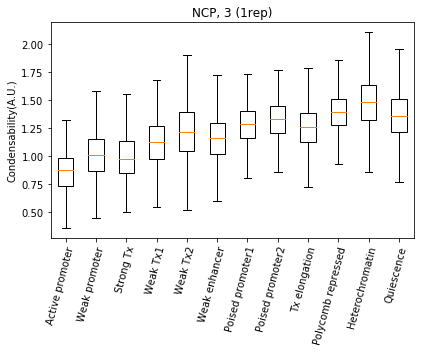


(1, 'NCP', 'score', 4)


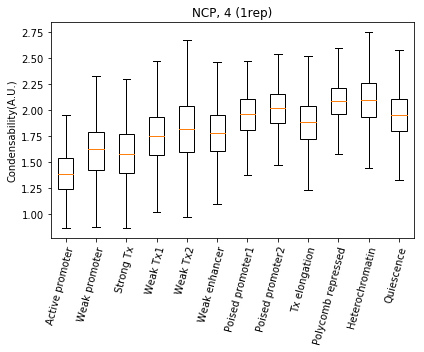


(1, 'NCP', 'score', 5)


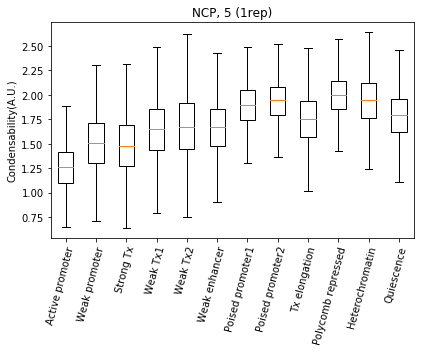


(1, 'NCP', 'score', 6)


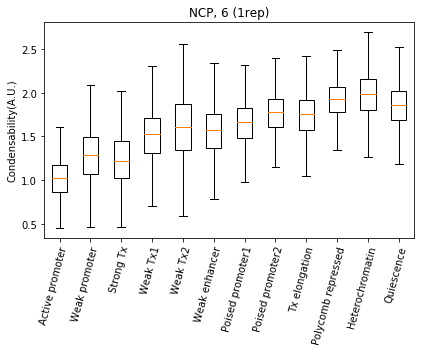


(1, 'NCP', 'score', 7)


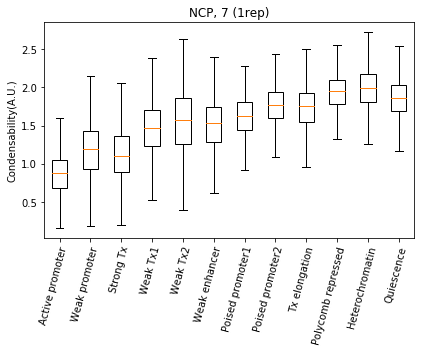


(1, 'NCP', 'score', 8)



(1, 'NCP', 'score', 9)


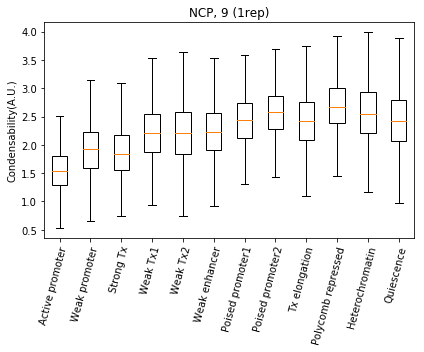


(1, 'NCPre1', 'ATcontent', 0)



(1, 'NCPre1', 'score', 1)



(1, 'NCPre1', 'score', 2)



(1, 'NCPre1', 'score', 3)


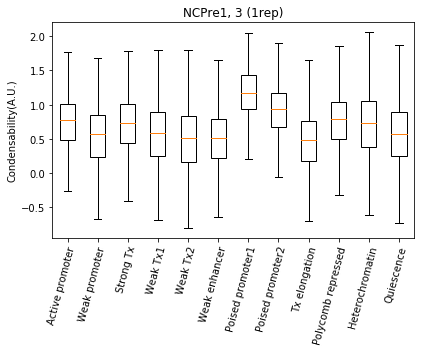


(1, 'NCPre1', 'score', 4)


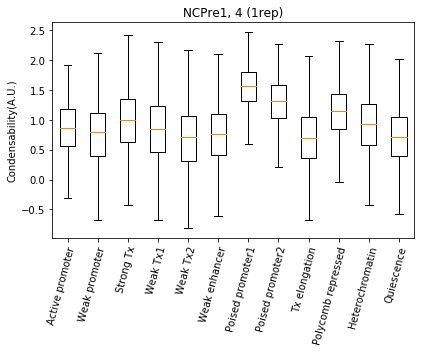


(1, 'NCPre1', 'score', 5)


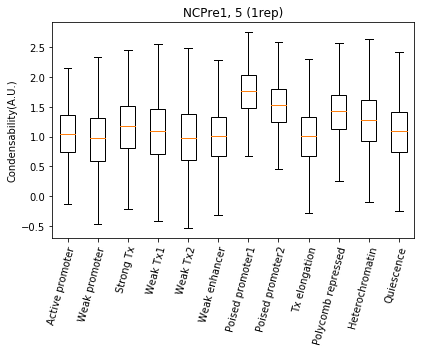


(1, 'NCPre1', 'score', 6)


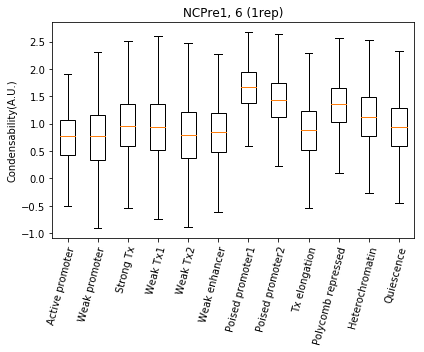


(1, 'NCPre1', 'score', 7)


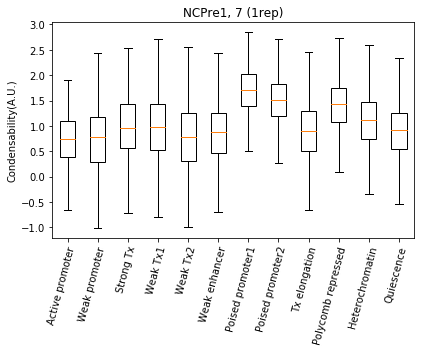


(1, 'NCPre1', 'score', 8)


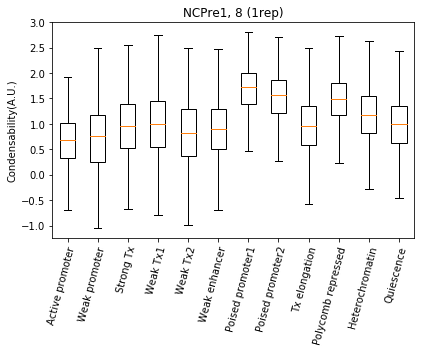


(1, 'NCPre1', 'score', 9)


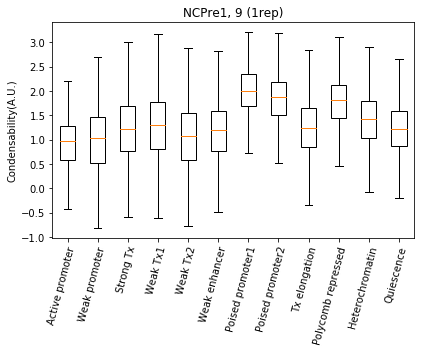


(1, 'NCPre2', 'score', 1)


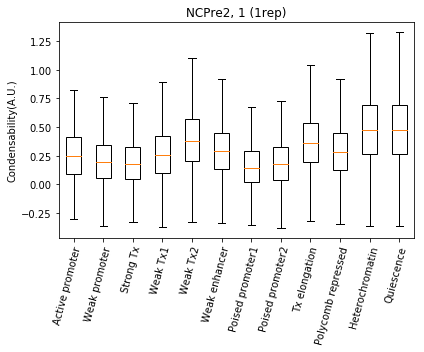


(1, 'NCPre2', 'score', 2)


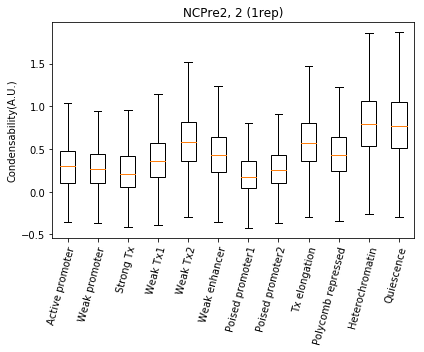


(1, 'NCPre2', 'score', 3)


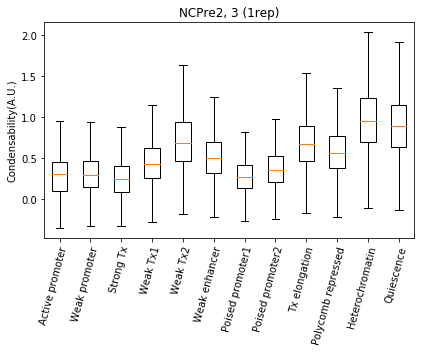


(1, 'NCPre2', 'score', 4)


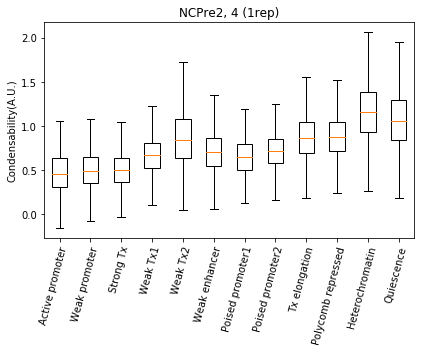


(1, 'NCPre2', 'score', 5)


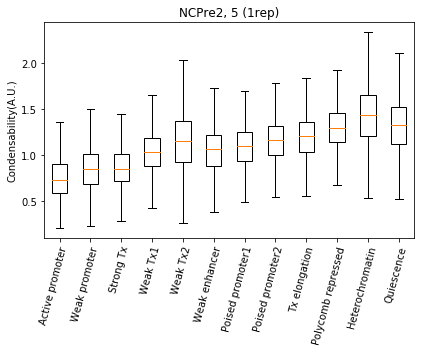


(1, 'NCPre2', 'score', 6)


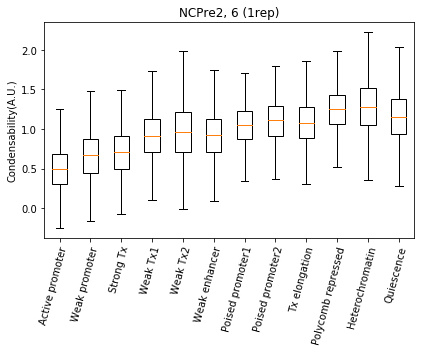


(1, 'NCPre2', 'score', 7)


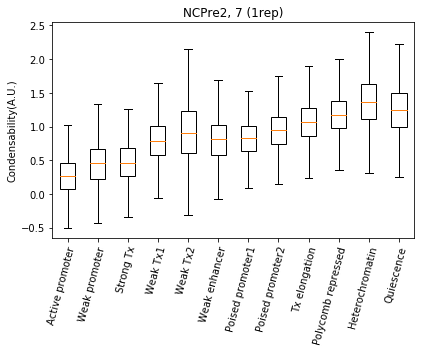


(1, 'NCPre2', 'score', 8)


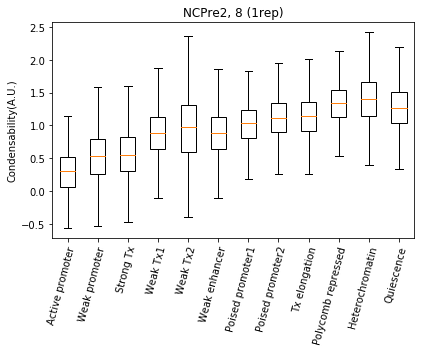


(1, 'NCPre2', 'score', 9)


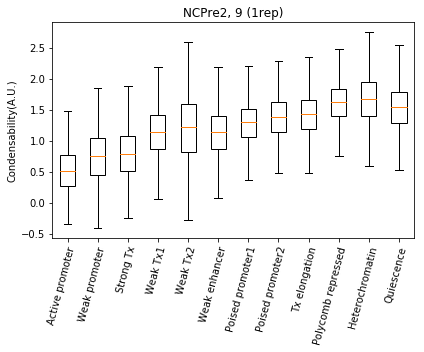


(1, 'NCPre3', 'score', 1)


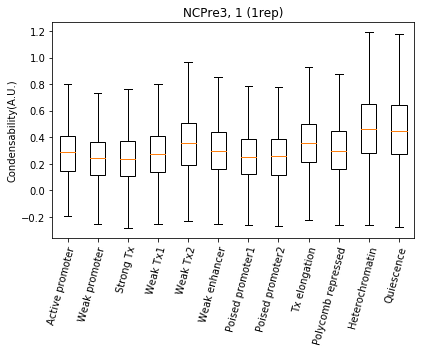


(1, 'NCPre3', 'score', 2)


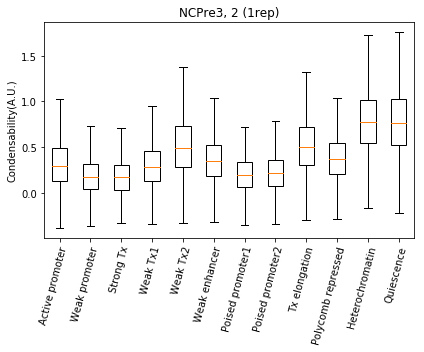


(1, 'NCPre3', 'score', 3)


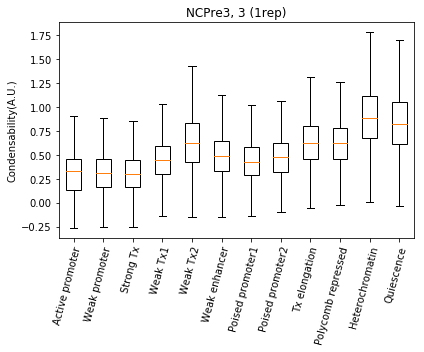


(1, 'NCPre3', 'score', 4)


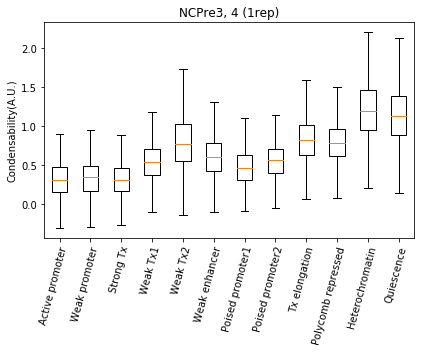


(1, 'NCPre3', 'score', 5)


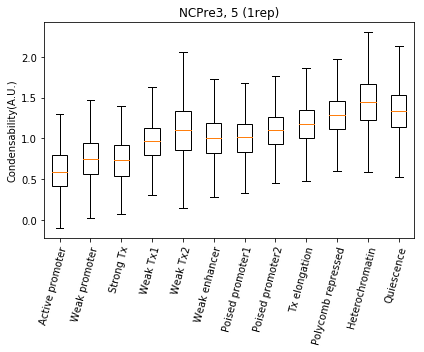


(1, 'NCPre3', 'score', 6)


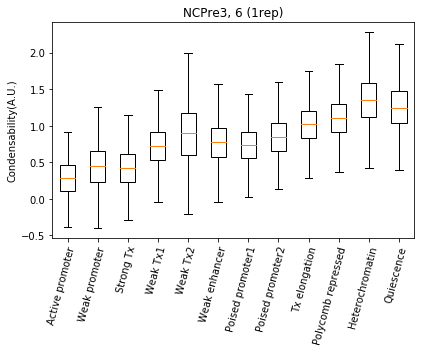


(1, 'NCPre3', 'score', 7)


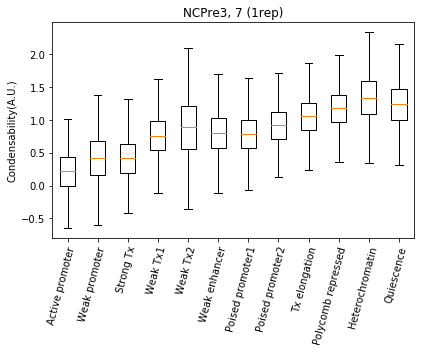


(1, 'NCPre3', 'score', 8)


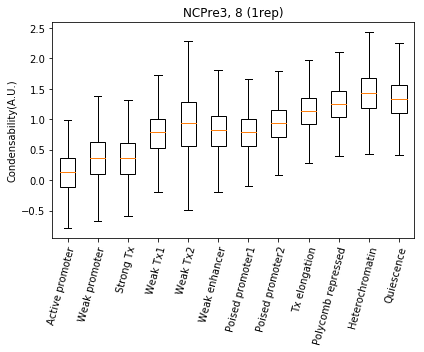


(1, 'NCPre3', 'score', 9)


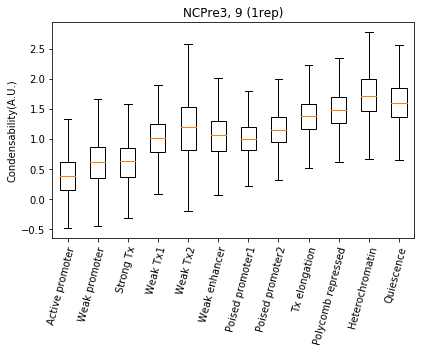


(1, 'NCPre4', 'score', 1)


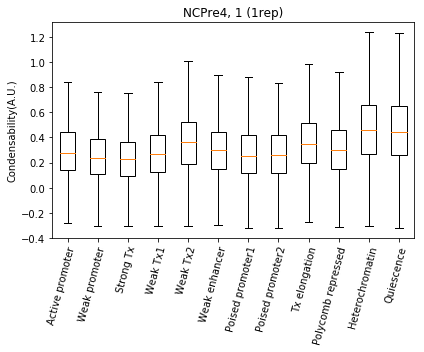


(1, 'NCPre4', 'score', 2)


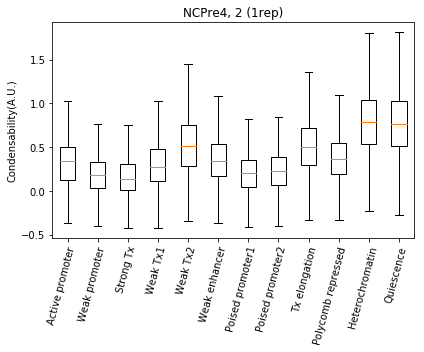


(1, 'NCPre4', 'score', 3)


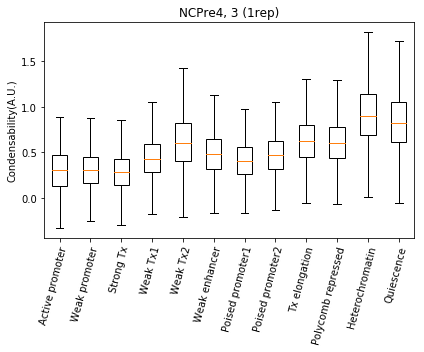


(1, 'NCPre4', 'score', 4)


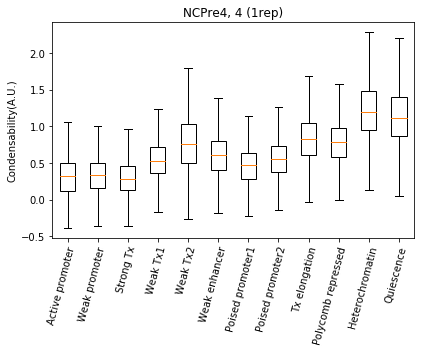


(1, 'NCPre4', 'score', 5)


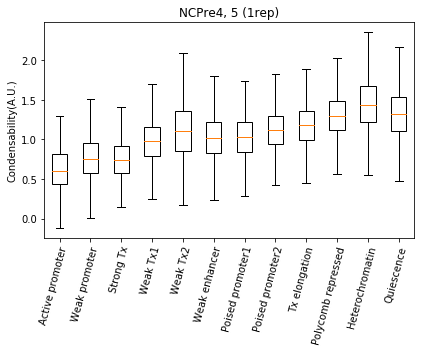


(1, 'NCPre4', 'score', 6)


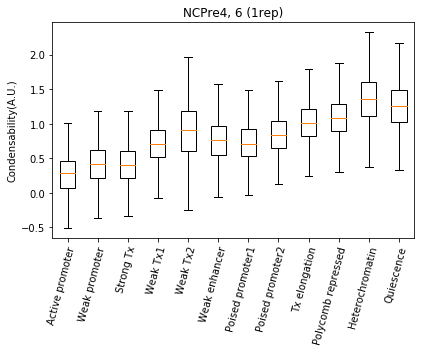


(1, 'NCPre4', 'score', 7)


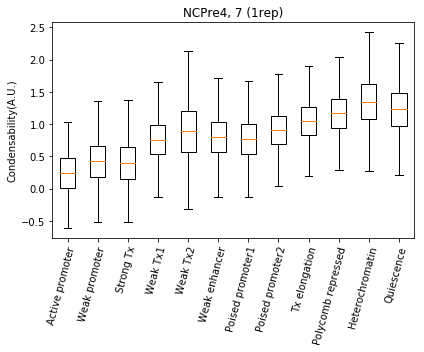


(1, 'NCPre4', 'score', 8)


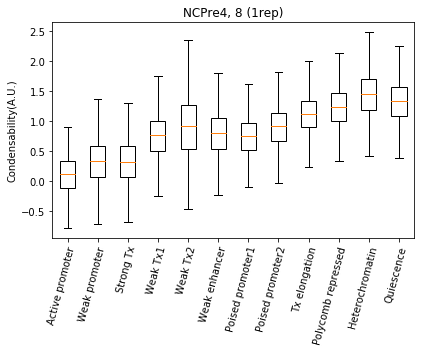


(1, 'NCPre4', 'score', 9)


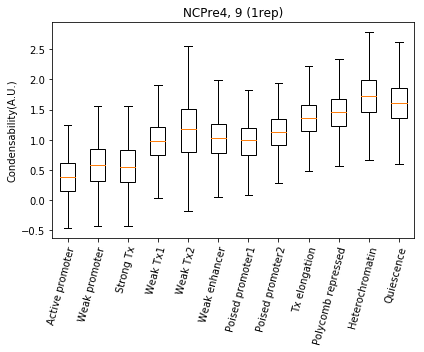

In [17]:
### plot the chromHMM
for dkey in sorted(dkey_state_values):
    print dkey
    cell = 'E14'
    state_values = dkey_state_values[dkey]
    graphics.plot_boxplot (state_values,
                           keys = cell_chromHMM[cell][-1],
                           fig_width=6,
                           fig_height=5,
                           ylabel='Condensability(A.U.)',
                           title='%s, %s (%drep)' % (dkey[1], dkey[3], dkey[0]),
                           rotation=75,
                           note='%s, %s (%drep)' % (dkey[1], dkey[3], dkey[0]),
                           save=True,
                           save_path='data/')
    print
    

(1, 'NCP', 'score', 1)


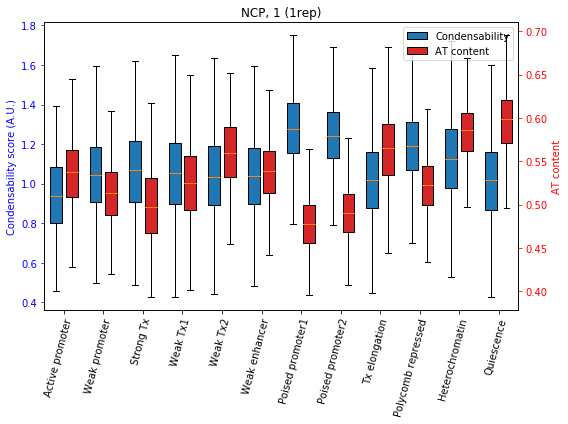


(1, 'NCP', 'score', 2)



(1, 'NCP', 'score', 3)



(1, 'NCP', 'score', 4)


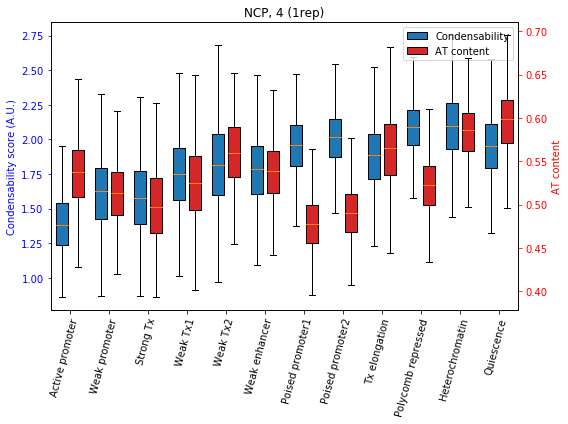


(1, 'NCP', 'score', 5)



(1, 'NCP', 'score', 6)


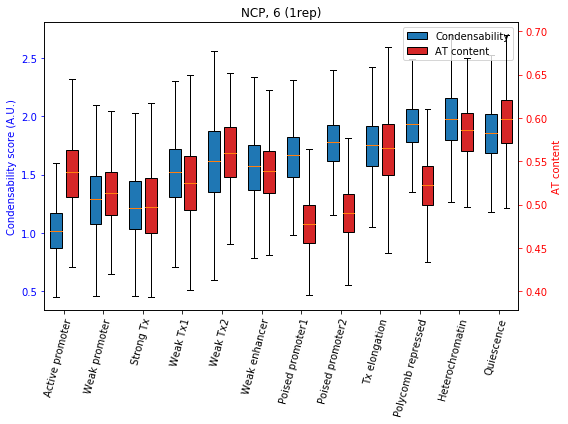


(1, 'NCP', 'score', 7)


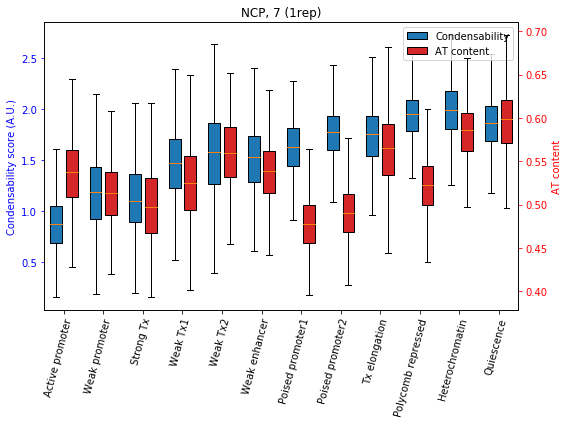


(1, 'NCP', 'score', 8)



(1, 'NCP', 'score', 9)


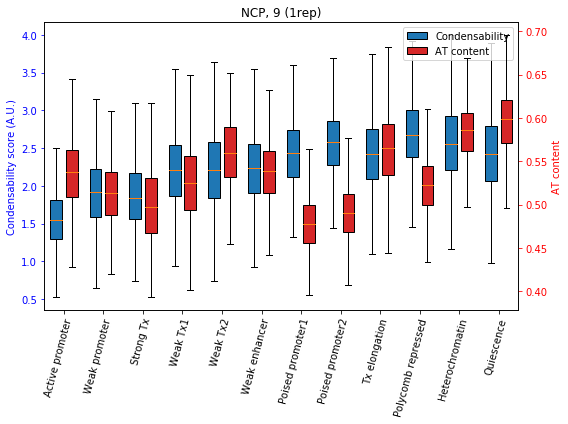


(1, 'NCPre1', 'score', 1)



(1, 'NCPre1', 'score', 2)


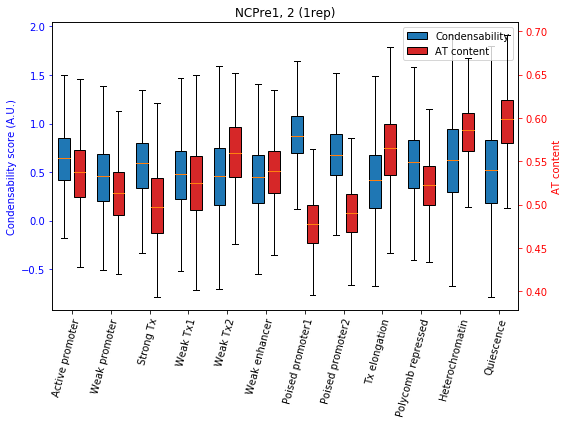


(1, 'NCPre1', 'score', 3)


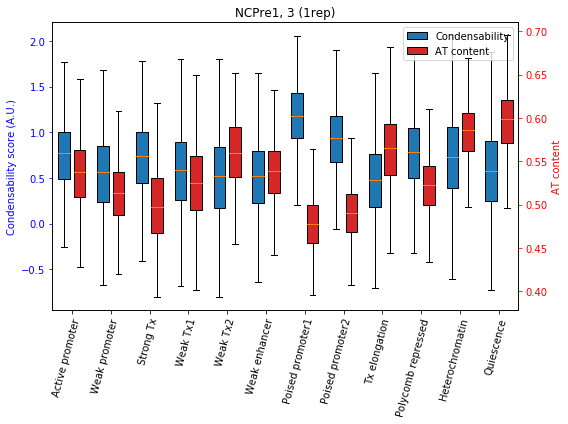


(1, 'NCPre1', 'score', 4)



(1, 'NCPre1', 'score', 5)


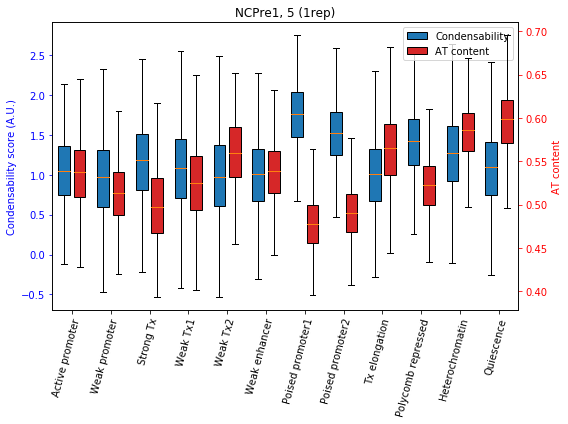


(1, 'NCPre1', 'score', 6)


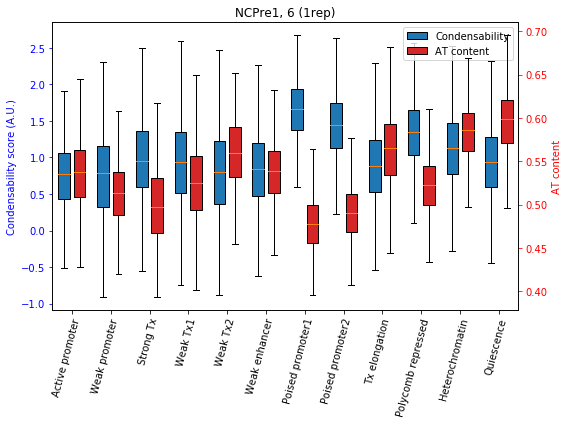


(1, 'NCPre1', 'score', 7)


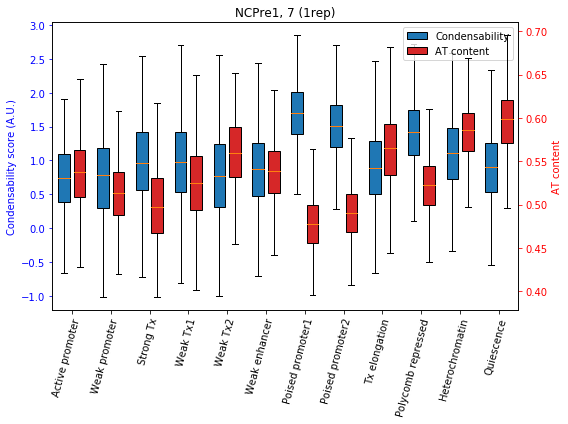


(1, 'NCPre1', 'score', 8)


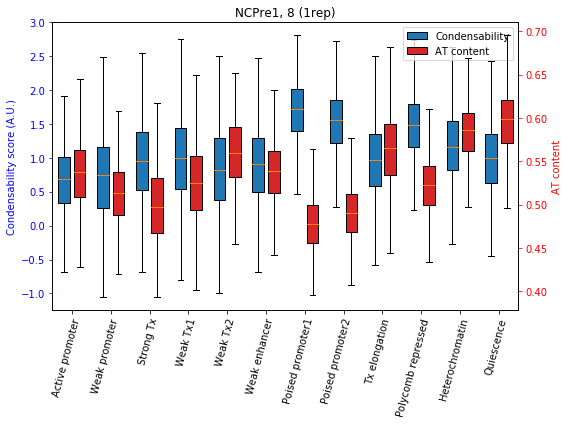


(1, 'NCPre1', 'score', 9)


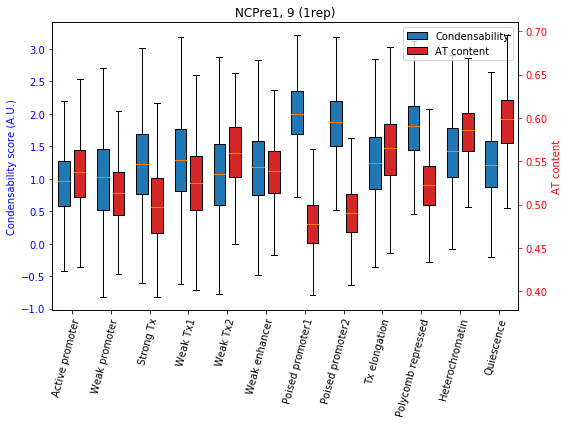


(1, 'NCPre2', 'score', 1)


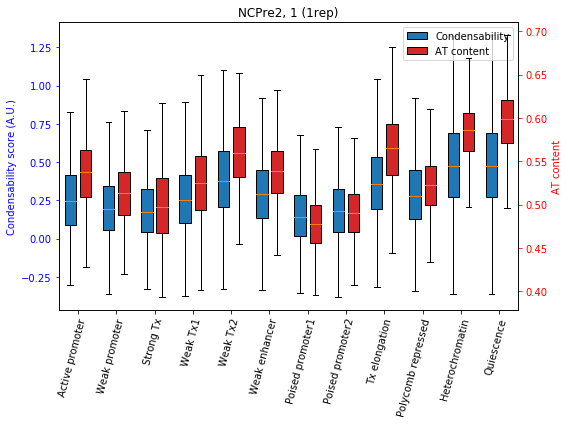


(1, 'NCPre2', 'score', 2)


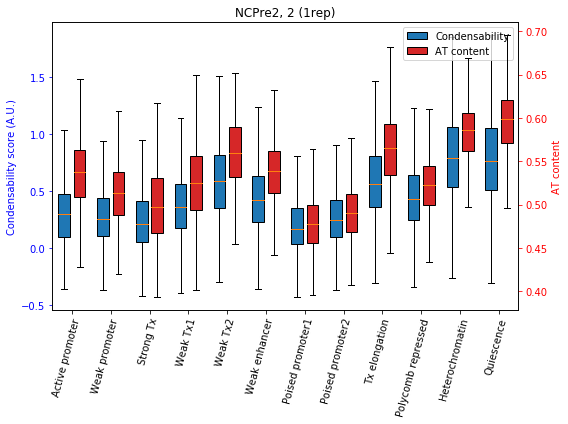


(1, 'NCPre2', 'score', 3)


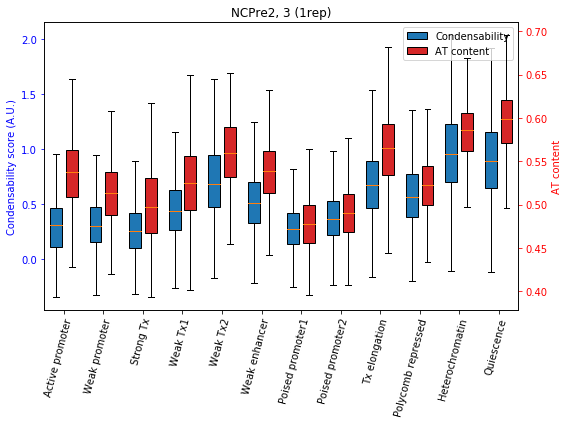


(1, 'NCPre2', 'score', 4)



(1, 'NCPre2', 'score', 5)


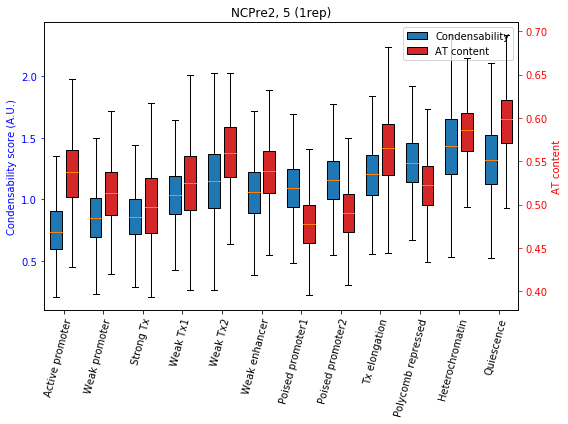


(1, 'NCPre2', 'score', 6)



(1, 'NCPre2', 'score', 7)


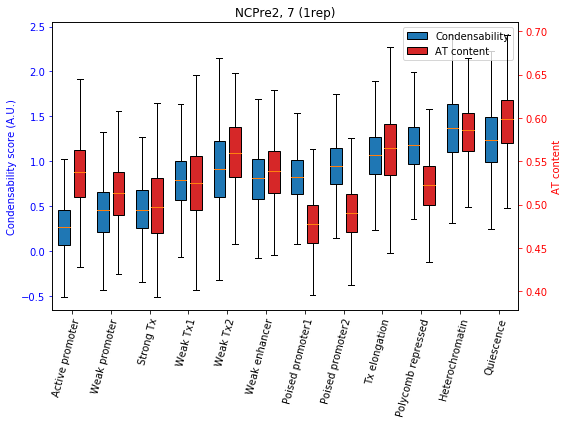


(1, 'NCPre2', 'score', 8)


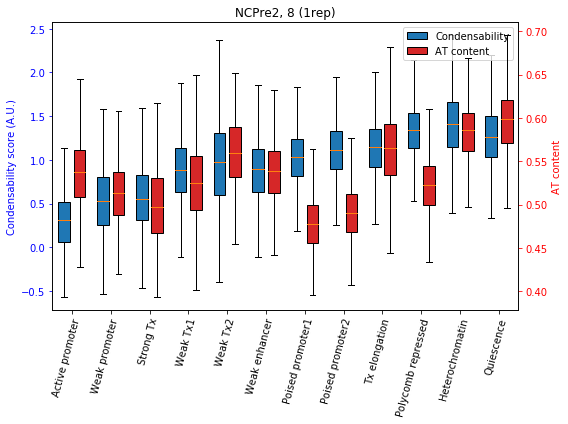


(1, 'NCPre2', 'score', 9)


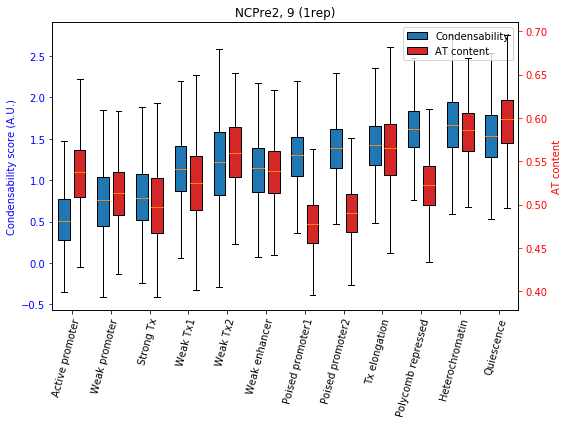


(1, 'NCPre3', 'score', 1)


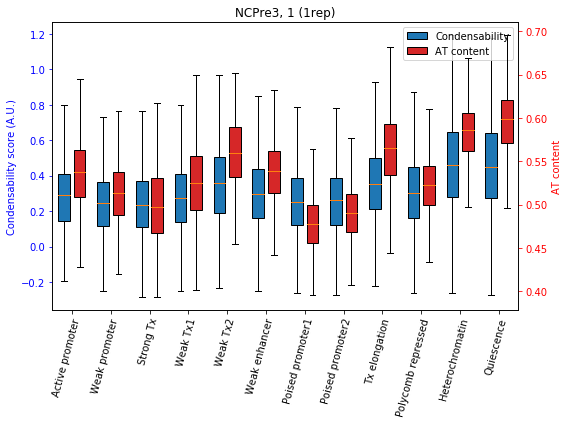


(1, 'NCPre3', 'score', 2)


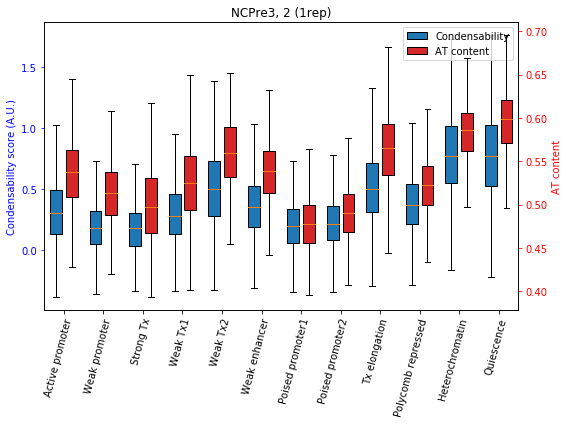


(1, 'NCPre3', 'score', 3)


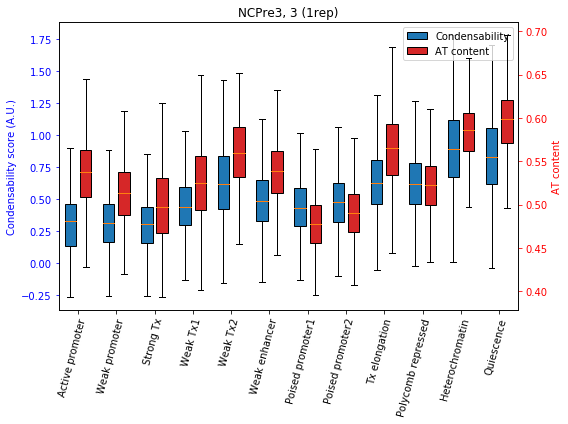


(1, 'NCPre3', 'score', 4)


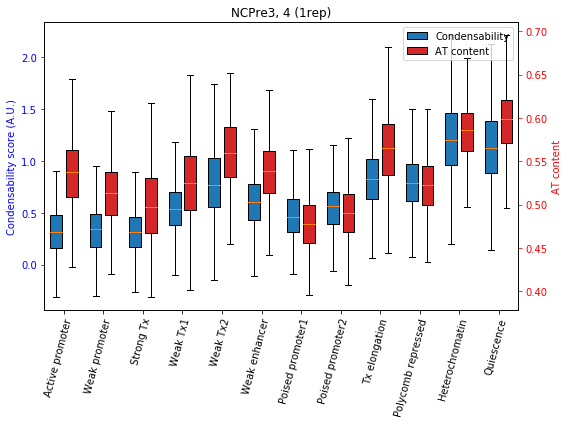


(1, 'NCPre3', 'score', 5)


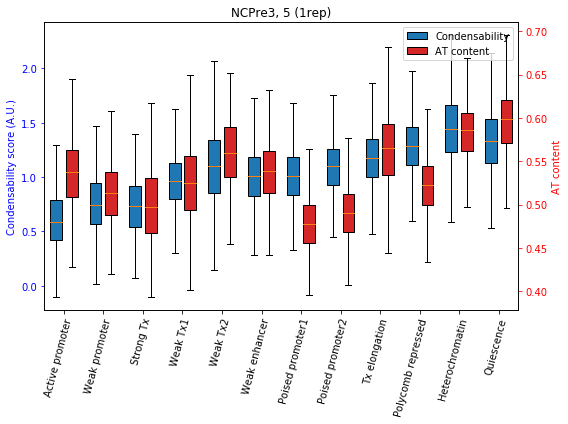


(1, 'NCPre3', 'score', 6)


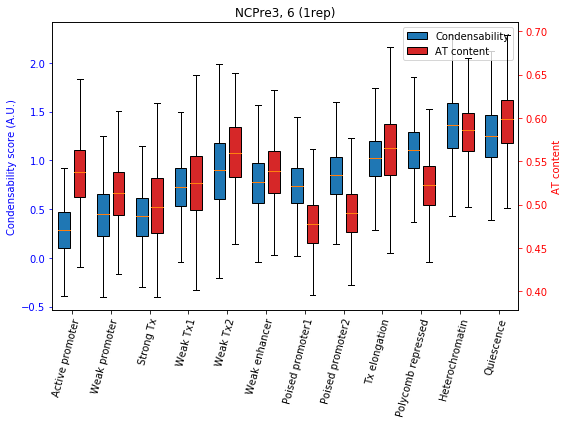


(1, 'NCPre3', 'score', 7)


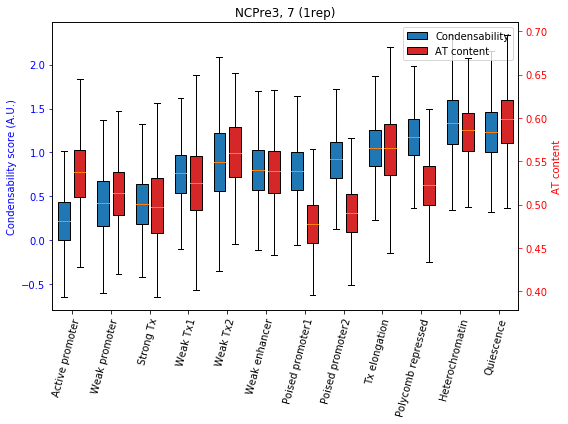


(1, 'NCPre3', 'score', 8)



(1, 'NCPre3', 'score', 9)



(1, 'NCPre4', 'score', 1)



(1, 'NCPre4', 'score', 2)



(1, 'NCPre4', 'score', 3)


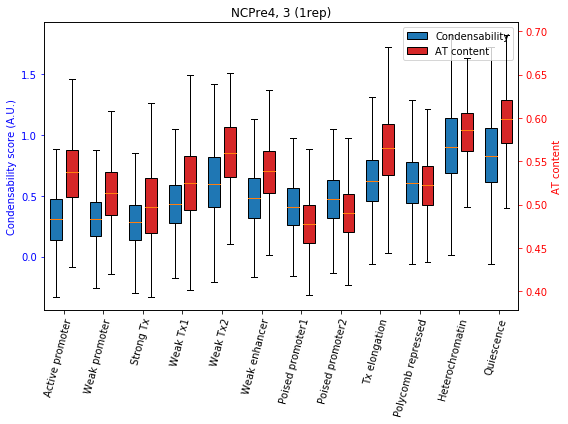


(1, 'NCPre4', 'score', 4)


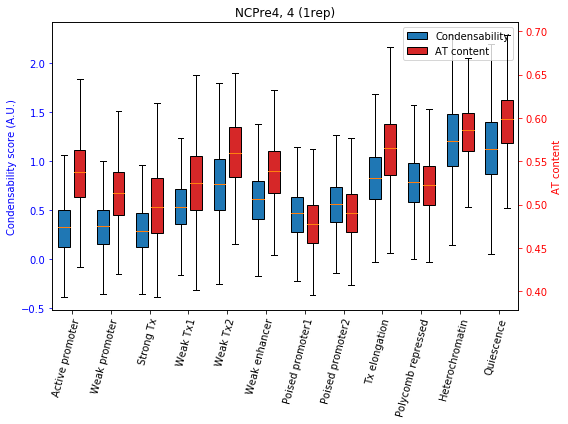


(1, 'NCPre4', 'score', 5)


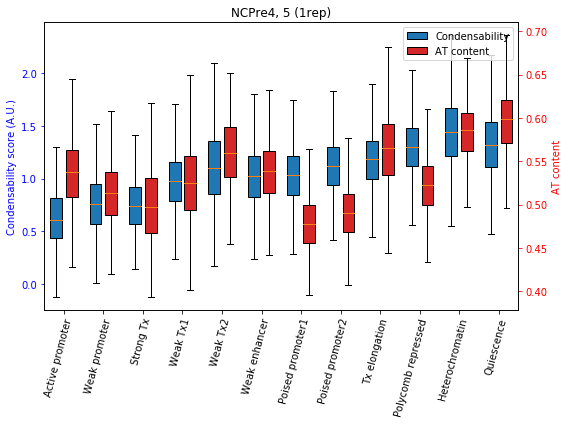


(1, 'NCPre4', 'score', 6)


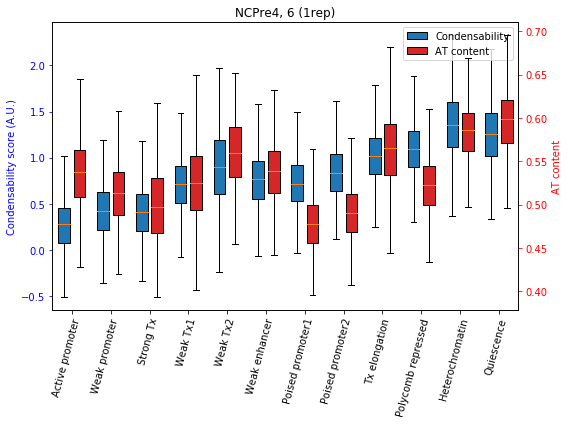


(1, 'NCPre4', 'score', 7)


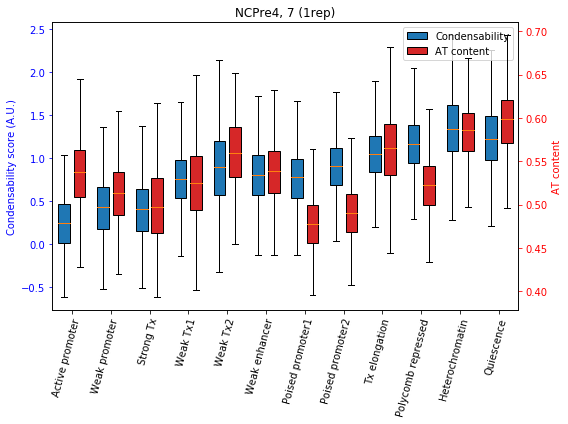


(1, 'NCPre4', 'score', 8)


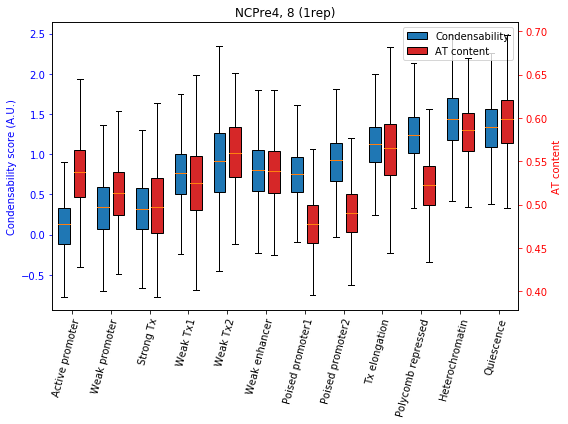


(1, 'NCPre4', 'score', 9)


In [18]:
for dkey in sorted(dkey_state_values):
    if dkey[2] == 'ATcontent':
        continue
    print dkey
    cell = 'E14'
    graphics.plot_boxplot_pair (dkey_state_values[dkey],
                                dkey_state_values[(1, 'NCP', 'ATcontent', 0)],
                                keys=cell_chromHMM[cell][-1],
                                color1='tab:blue',
                                color2='tab:red',
                                ycolor1='blue',
                                ycolor2='red',
                                ylabel1='Condensability score (A.U.)',
                                ylabel2='AT content',
                                label1='Condensability',
                                label2='AT content',
                                legend_loc='best',
                                title='%s, %s (%drep)' % (dkey[1], dkey[3], dkey[0]),
                                rotation=75,
                                note='%s, %s (%drep)' % (dkey[1], dkey[3], dkey[0]),
                                save=True,
                                save_path='data/')
    print

In [19]:
### plot multiple chromHMM (single nucleosome)
#marks = ['H3K27ac', 'H3K27me3']
marks = ['score']
reps = [1, 2]
for mark in marks:
    for rep in reps:
        graphics.plot_boxplot_multiple ([dkey_state_values[(rep, 'mCD8T:WT', mark)],
                                         dkey_state_values[(rep, 'mCD8T:DFMO', mark)]],
                                        keys=mCD8T_states,
                                        ylabel='Condensability score (A.U.)',
                                        title='%s, WT vs +DFMO (%drep)' % (mark, rep),
                                        rotation=45,
                                        colors=['tab:blue',
                                                'tab:orange'],
                                        labels=['WT',
                                                '+DFMO'],
                                        legend_loc='best',
                                        save=True,
                                        note='%s_WTvs+DFMO_%drep' % (mark, rep))
        print

KeyError: (1, 'mCD8T:WT', 'score')

In [20]:
### plot multiple chromHMM (single nucleosome)
#marks = ['H3K27ac', 'H3K27me3']
marks = ['score']
reps = [1, 2]
for mark in marks:
    for rep in reps:
        graphics.plot_boxplot_multiple ([dkey_state_values[(rep, 'E14', mark)],
                                         dkey_state_values['ATcontent']],
                                        keys=mCD8T_states,
                                        ylabel='Condensability score (A.U.)',
                                        title='%s, WT vs +DFMO vs ODCKO (%drep)' % (mark, rep),
                                        rotation=45,
                                        colors=['tab:blue',
                                                'tab:orange',
                                                'tab:green'],
                                        labels=['WT',
                                                '+DFMO',
                                                'ODC-KO'],
                                        legend_loc='best',
                                        save=True,
                                        note='%s_WTvs+DFMOvsODCKO_%drep' % (mark, rep))
        print

KeyError: (1, 'E14', 'score')

In [21]:
### statistical testing for comparing two conditions
#reps = [1,2,3]
#marks = ['H3K27ac', 'H3K27me3']
reps = [1, 2]
marks = ['score']
dkey_testing_state_pvalue = {}
for testing in ['ttest']:
    for rep in reps:
        for mark in marks:
            dkey1 = (rep, 'mCD8T:WT', mark)
            dkey2 = (rep, 'mCD8T:DFMO', mark)

            state_IDs1 = dkey_state_IDs[dkey1]
            chr_ID_value1 = dkey_chr_ID_value[dkey1]
            state_values1 = {}
            for state, IDs in state_IDs1.items():
                values1 = [chr_ID_value1[ID[0]][ID] for ID in IDs]
                if state not in state_values1:
                    state_values1[state] = []
                state_values1[state] += values1

            state_IDs2 = dkey_state_IDs[dkey2]
            chr_ID_value2 = dkey_chr_ID_value[dkey2]
            state_values2 = {}
            for state, IDs in state_IDs2.items():
                values2 = [chr_ID_value2[ID[0]][ID] for ID in IDs]
                if state not in state_values2:
                    state_values2[state] = []
                state_values2[state] += values2

            for state in mCD8T_states:
                values1 = state_values1[state]
                values2 = state_values2[state]
                
                if testing == 'ttest':
                    pvalue = stats.ttest_ind(values1, values2, equal_var=False)[1]
                elif testing == 'mannwhitneyu':
                    pvalue = stats.mannwhitneyu(values1, values2)[1]
                elif testing == 'kruskal':
                    pvalue = stats.kruskal(values1, values2)[1]

                if (rep, 'DFMOvsWT', mark) not in dkey_testing_state_pvalue:
                    dkey_testing_state_pvalue[(rep, 'DFMOvsWT', mark)] = {}
                if testing not in dkey_testing_state_pvalue[(rep, 'DFMOvsWT', mark)]:
                    dkey_testing_state_pvalue[(rep, 'DFMOvsWT', mark)][testing] = {}
                dkey_testing_state_pvalue[(rep, 'DFMOvsWT', mark)][testing][state] = pvalue
            

        

KeyError: (1, 'mCD8T:WT', 'score')

In [22]:

#for mark in ['H3K27ac', 'H3K27me3']:
for mark in ['score']:
    for rep in [1,2]:
        dkey = (rep, 'DFMOvsWT', mark)
        print dkey
        testing_state_pvalue = dkey_testing_state_pvalue[dkey]
        for testing in testing_state_pvalue:
            state_pvalue = testing_state_pvalue[testing]
            for state in mCD8T_states:
                pvalue = state_pvalue[state]
                #print state, pvalue
                if pvalue > 0.05:
                    print state, state_pvalue[state]
        print 

(1, 'DFMOvsWT', 'score')


KeyError: (1, 'DFMOvsWT', 'score')

In [23]:
### statistical testing
testings = ['ttest', 'mannwhitneyu', 'kruskal']
dkey_testing_pair_pvalue = {}
for dkey in dkey_state_IDs:
    state_IDs = dkey_state_IDs[dkey]
    chr_ID_value = dkey_chr_ID_value[dkey]
    
    state_values = {}
    for state, IDs in state_IDs.items():
        values = [chr_ID_value[ID[0]][ID] for ID in IDs]
        if state not in state_values:
            state_values[state] = []
        state_values[state] += values

    cell = dkey[1]

    if cell == 'H1':
        states = H1_states
    elif cell == 'GM':
        states = GM_states
    elif cell == 'mCD8T':
        states = mCD8T_states

    testing_pair_pvalue = {}
    for i in range(len(states)-1):
        for j in range(i+1, len(states)):
            
            state1 = states[i]
            state2 = states[j]
            values1 = state_values[state1]
            values2 = state_values[state2]
            
            pair = (state1, state2)
            for testing in testings:
                if testing == 'ttest':
                    pvalue = stats.ttest_ind(values1, values2, equal_var=False)[1]
                elif testing == 'mannwhitneyu':
                    pvalue = stats.mannwhitneyu(values1, values2)[1]
                elif testing == 'kruskal':
                    pvalue = stats.kruskal(values1, values2)[1]

                if testing not in testing_pair_pvalue:
                    testing_pair_pvalue[testing] = {}
                
                assert pair not in testing_pair_pvalue[testing]
                testing_pair_pvalue[testing][pair] = pvalue

    dkey_testing_pair_pvalue[dkey] = testing_pair_pvalue

In [24]:
for dkey in dkey_state_IDs:
    state_IDs = dkey_state_IDs[dkey]
    cell = dkey[1]

    if cell == 'H1':
        states = H1_states
    elif cell == 'GM':
        states = GM_states
    elif cell == 'mCD8T':
        states = mCD8T_states

    print dkey

    for state in states:
        print state, np.log10(len(state_IDs[state]))
    

(1, 'NCPre1', 'score', 5)
Active promoter 2.656098202012832
Weak promoter 3.1911714557285586
Strong Tx 2.9469432706978256
Weak Tx1 3.6868149545073168
Weak Tx2 3.0530784434834195
Weak enhancer 3.9909157545060845
Poised promoter1 2.9185545305502734
Poised promoter2 3.04883008652835
Tx elongation 4.226599905207357
Polycomb repressed 4.213411494582782
Heterochromatin 3.9533246963891853
Quiescence 5.306639441024261
(1, 'NCP', 'score', 1)
Active promoter 2.656098202012832
Weak promoter 3.1911714557285586
Strong Tx 2.9469432706978256
Weak Tx1 3.6869042695681773
Weak Tx2 3.0549958615291417
Weak enhancer 3.991137435120312
Poised promoter1 2.9185545305502734
Poised promoter2 3.04883008652835
Tx elongation 4.227732489846626
Polycomb repressed 4.213517756996305
Heterochromatin 3.9576551669434914
Quiescence 5.31778554822776
(1, 'NCPre2', 'score', 7)
Active promoter 2.656098202012832
Weak promoter 3.1911714557285586
Strong Tx 2.9469432706978256
Weak Tx1 3.6869042695681773
Weak Tx2 3.0549958615291417

('Active promoter', 'Weak promoter') 1.6654022090519625
('Active promoter', 'Strong Tx') 5.229969426435173
('Active promoter', 'Weak Tx1') 1.8280409097239514
('Active promoter', 'Weak Tx2') 0.31193520259023255
('Active promoter', 'Weak enhancer') 0.4129738318576569
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 0.14002865291360087
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 2.868261800558954
('Weak promoter', 'Strong Tx') 9.999999946979713
('Weak promoter', 'Weak Tx1') 9.999966845249855
('Weak promoter', 'Weak Tx2') 1.261322752599348
('Weak promoter', 'Weak enhancer') 2.386754038406368
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 3.8871321695224323
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', '

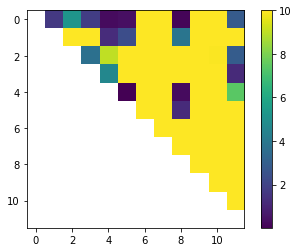

('Active promoter', 'Weak promoter') 2.3507840235157245
('Active promoter', 'Strong Tx') 5.376969376538473
('Active promoter', 'Weak Tx1') 1.5799308312365299
('Active promoter', 'Weak Tx2') 1.1690032222476547
('Active promoter', 'Weak enhancer') 1.2074862865046467
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 0.9440621190547039
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 9.999999999999456
('Active promoter', 'Quiescence') 1.70331436870529
('Weak promoter', 'Strong Tx') 9.999999997693832
('Weak promoter', 'Weak Tx1') 9.999947343324095
('Weak promoter', 'Weak Tx2') 1.1081522898077607
('Weak promoter', 'Weak enhancer') 2.4143961544989554
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 3.4585848354224695
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak 

10.0
('Strong Tx', 'Poised promoter2') 10.0
('Strong Tx', 'Tx elongation') 9.999999973913638
('Strong Tx', 'Polycomb repressed') 10.0
('Strong Tx', 'Heterochromatin') 8.65162119555588
('Strong Tx', 'Quiescence') 5.407838630565326
('Weak Tx1', 'Weak Tx2') 6.153327657022001
('Weak Tx1', 'Weak enhancer') 9.999999999331521
('Weak Tx1', 'Poised promoter1') 10.0
('Weak Tx1', 'Poised promoter2') 10.0
('Weak Tx1', 'Tx elongation') 9.99999997458836
('Weak Tx1', 'Polycomb repressed') 10.0
('Weak Tx1', 'Heterochromatin') 10.0
('Weak Tx1', 'Quiescence') 0.3849040119000988
('Weak Tx2', 'Weak enhancer') 0.5094577257005369
('Weak Tx2', 'Poised promoter1') 10.0
('Weak Tx2', 'Poised promoter2') 10.0
('Weak Tx2', 'Tx elongation') 0.8351007536189483
('Weak Tx2', 'Polycomb repressed') 10.0
('Weak Tx2', 'Heterochromatin') 10.0
('Weak Tx2', 'Quiescence') 8.273991369124237
('Weak enhancer', 'Poised promoter1') 10.0
('Weak enhancer', 'Poised promoter2') 10.0
('Weak enhancer', 'Tx elongation') 1.04879950292039

('Active promoter', 'Weak promoter') 2.049812647603979
('Active promoter', 'Strong Tx') 5.076095877133638
('Active promoter', 'Weak Tx1') 1.2789169540981955
('Active promoter', 'Weak Tx2') 0.8680242771121823
('Active promoter', 'Weak enhancer') 0.9064632454972541
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 0.6430356281762167
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 9.999999999998915
('Active promoter', 'Quiescence') 1.4022847966693608
('Weak promoter', 'Strong Tx') 9.999999995388897
('Weak promoter', 'Weak Tx1') 9.999894699455554
('Weak promoter', 'Weak Tx2') 0.8071427911104712
('Weak promoter', 'Weak enhancer') 2.1133715487799405
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 3.157558857523251
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak 

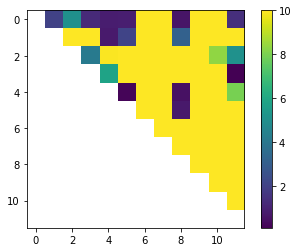

('Active promoter', 'Weak promoter') 9.99999999999354
('Active promoter', 'Strong Tx') 9.999999999999957
('Active promoter', 'Weak Tx1') 9.999999999999998
('Active promoter', 'Weak Tx2') 9.999999942020766
('Active promoter', 'Weak enhancer') 9.999999999991202
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 9.999965909924489
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 9.999981120304
('Weak promoter', 'Strong Tx') 1.1796569265394214
('Weak promoter', 'Weak Tx1') 0.13065663088733445
('Weak promoter', 'Weak Tx2') 0.18347420073694656
('Weak promoter', 'Weak enhancer') 1.1239384257896963
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 6.921033281667698
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiesc

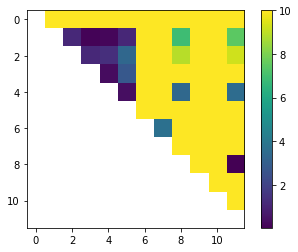

('Active promoter', 'Weak promoter') 9.999999999988232
('Active promoter', 'Strong Tx') 9.999999999999218
('Active promoter', 'Weak Tx1') 9.999999999999963
('Active promoter', 'Weak Tx2') 9.999998364848109
('Active promoter', 'Weak enhancer') 9.999999999996769
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 9.999965034433174
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 9.999780010205955
('Weak promoter', 'Strong Tx') 1.5148759276385544
('Weak promoter', 'Weak Tx1') 0.4883859294051313
('Weak promoter', 'Weak Tx2') 0.753550146991498
('Weak promoter', 'Weak enhancer') 1.3574718930659422
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 7.263111522115871
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quies

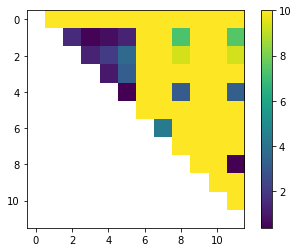

('Active promoter', 'Weak promoter') 9.999999999976476
('Active promoter', 'Strong Tx') 9.999999999998437
('Active promoter', 'Weak Tx1') 9.999999999999927
('Active promoter', 'Weak Tx2') 9.99999673132342
('Active promoter', 'Weak enhancer') 9.999999999993538
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 9.999930074275312
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 9.999560133091652
('Weak promoter', 'Strong Tx') 1.2138753071212791
('Weak promoter', 'Weak Tx1') 0.18735971925663183
('Weak promoter', 'Weak Tx2') 0.4525361994992411
('Weak promoter', 'Weak enhancer') 1.0564457284890658
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 6.962485621484129
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quie

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.9694888448232758
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.9447798039836003
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 

('Active promoter', 'Weak promoter') 9.999999999999998
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.6437718173625262
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised

('Active promoter', 'Weak promoter') 9.999999999999835
('Active promoter', 'Strong Tx') 2.780941375298122
('Active promoter', 'Weak Tx1') 9.99999999993159
('Active promoter', 'Weak Tx2') 9.999941826389643
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 1.296239250704944
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 2.078522496462545
('Active promoter', 'Heterochromatin') 0.23129984545785126
('Active promoter', 'Quiescence') 9.801494244726426
('Weak promoter', 'Strong Tx') 9.999999997429612
('Weak promoter', 'Weak Tx1') 1.683109060100944
('Weak promoter', 'Weak Tx2') 1.23768687629257
('Weak promoter', 'Weak enhancer') 0.5015117016554178
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 3.007035685821714
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promot

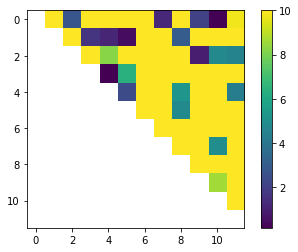

('Active promoter', 'Weak promoter') 9.999999999999996
('Active promoter', 'Strong Tx') 2.9073690724997223
('Active promoter', 'Weak Tx1') 9.999999999914023
('Active promoter', 'Weak Tx2') 9.999993592315658
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 1.3932363878764733
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 2.466430114270877
('Active promoter', 'Heterochromatin') 0.7725359851170901
('Active promoter', 'Quiescence') 9.474735137994369
('Weak promoter', 'Strong Tx') 9.999999999976248
('Weak promoter', 'Weak Tx1') 2.7292032681656977
('Weak promoter', 'Weak Tx2') 0.9582197200398282
('Weak promoter', 'Weak enhancer') 0.6140456964086924
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 2.6212300736596057
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak 

('Active promoter', 'Weak promoter') 9.999999999999995
('Active promoter', 'Strong Tx') 2.6064464813361896
('Active promoter', 'Weak Tx1') 9.999999999828072
('Active promoter', 'Weak Tx2') 9.999987190973002
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 1.0922636671226176
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 2.165406545255841
('Active promoter', 'Heterochromatin') 0.4715117205804141
('Active promoter', 'Quiescence') 9.243867412089369
('Weak promoter', 'Strong Tx') 9.999999999952509
('Weak promoter', 'Weak Tx1') 2.4281841877030965
('Weak promoter', 'Weak Tx2') 0.657208456295443
('Weak promoter', 'Weak enhancer') 0.3130180322493997
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 2.3202034663797715
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak p

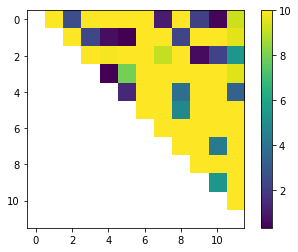

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 1.625045730173661
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 1

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 2.372858183955
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 10.0

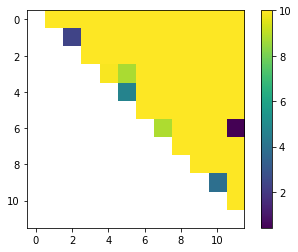

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 2.071866440359873
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 1

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 2.700175707992905
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 1

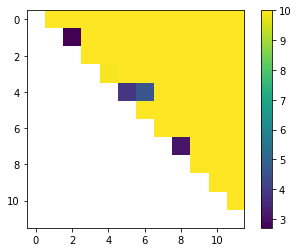

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 3.828319366062408
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 1

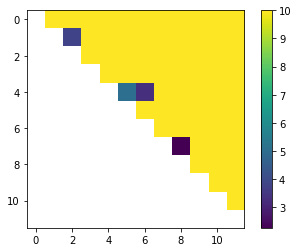

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 3.5273397025376796
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 

 10.0
('Weak enhancer', 'Polycomb repressed') 10.0
('Weak enhancer', 'Heterochromatin') 10.0
('Weak enhancer', 'Quiescence') 10.0
('Poised promoter1', 'Poised promoter2') 10.0
('Poised promoter1', 'Tx elongation') 10.0
('Poised promoter1', 'Polycomb repressed') 10.0
('Poised promoter1', 'Heterochromatin') 10.0
('Poised promoter1', 'Quiescence') 10.0
('Poised promoter2', 'Tx elongation') 1.9612395035397847
('Poised promoter2', 'Polycomb repressed') 10.0
('Poised promoter2', 'Heterochromatin') 10.0
('Poised promoter2', 'Quiescence') 10.0
('Tx elongation', 'Polycomb repressed') 10.0
('Tx elongation', 'Heterochromatin') 10.0
('Tx elongation', 'Quiescence') 10.0
('Polycomb repressed', 'Heterochromatin') 10.0
('Polycomb repressed', 'Quiescence') 10.0
('Heterochromatin', 'Quiescence') 10.0
kruskal


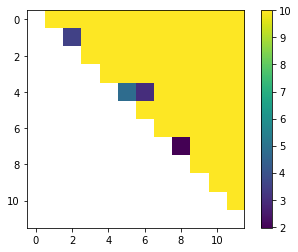

('Active promoter', 'Weak promoter') 9.999999999999362
('Active promoter', 'Strong Tx') 9.999999927345213
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.40441417836453675
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Stron

('Active promoter', 'Weak promoter') 9.999999999997176
('Active promoter', 'Strong Tx') 9.999993148161913
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 1.0651509163547626
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong

('Active promoter', 'Weak promoter') 9.999999999994353
('Active promoter', 'Strong Tx') 9.999986304632769
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.764144631476384
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong 

('Active promoter', 'Weak promoter') 9.99999999999701
('Active promoter', 'Strong Tx') 9.999999999999991
('Active promoter', 'Weak Tx1') 1.3163344201432918
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 2.0141795606459736
('Active promoter', 'Poised promoter1') 9.99999526792377
('Active promoter', 'Poised promoter2') 9.672767802907172
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 4.037537369198909
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 1.253019557665092
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 0.8592265695502896
('Weak promoter', 'Poised promoter2') 5.530151266880501
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', '

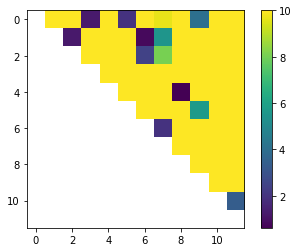

('Active promoter', 'Weak promoter') 9.999999999999966
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 2.236611422154684
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 1.6635410335358385
('Active promoter', 'Poised promoter1') 9.999998723695047
('Active promoter', 'Poised promoter2') 9.928232470545245
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 3.5549788363280515
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 2.6855185817745904
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 1.093870157169648
('Weak promoter', 'Poised promoter2') 5.435416026857956
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 

('Active promoter', 'Weak promoter') 9.999999999999934
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 1.9356012024041596
('Active promoter', 'Weak Tx2') 9.999999999999998
('Active promoter', 'Weak enhancer') 1.362519469730693
('Active promoter', 'Poised promoter1') 9.999997449047369
('Active promoter', 'Poised promoter2') 9.866707397867968
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 3.2539568202570512
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 2.3845296657989135
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 0.7928653562034494
('Weak promoter', 'Poised promoter2') 5.134443695986096
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx'

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 5.803028879072393
('Active promoter', 'Weak Tx2') 9.99999999999998
('Active promoter', 'Weak enhancer') 1.0500237365935148
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 9.650354271444156
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 9.999842495679188
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 6.690834447804403
('Active promoter', 'Weak Tx2') 9.999999999999993
('Active promoter', 'Weak enhancer') 0.7451239525244601
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 9.999986291478876
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 9.999991963509538
('Weak promoter', 'Weak Tx1') 9.999999999999998
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Str

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 6.3899475109187
('Active promoter', 'Weak Tx2') 9.999999999999986
('Active promoter', 'Weak enhancer') 0.44409910191112195
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 9.999972584456971
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 9.999983931008122
('Weak promoter', 'Weak Tx1') 9.999999999999996
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Stro

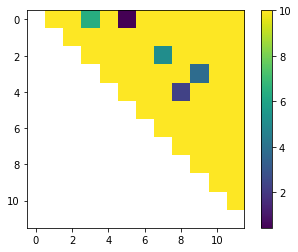

('Active promoter', 'Weak promoter') 2.849862555928047
('Active promoter', 'Strong Tx') 4.432774940461071
('Active promoter', 'Weak Tx1') 0.5640398446110307
('Active promoter', 'Weak Tx2') 7.502038388613631
('Active promoter', 'Weak enhancer') 0.7204698854317643
('Active promoter', 'Poised promoter1') 1.2265290598315652
('Active promoter', 'Poised promoter2') 1.1217276267085934
('Active promoter', 'Tx elongation') 9.844399592247566
('Active promoter', 'Polycomb repressed') 1.23173839716952
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 1.0388819819784227
('Weak promoter', 'Weak Tx1') 4.721799368092964
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 9.999999999779456
('Weak promoter', 'Poised promoter1') 0.734957228414472
('Weak promoter', 'Poised promoter2') 1.2128297159741817
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 1

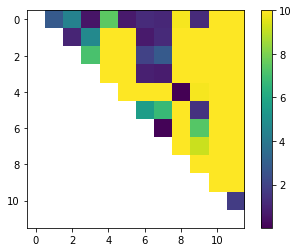

('Active promoter', 'Weak promoter') 3.542673188585597
('Active promoter', 'Strong Tx') 5.147012692387727
('Active promoter', 'Weak Tx1') 0.9796875617255987
('Active promoter', 'Weak Tx2') 6.745759782970463
('Active promoter', 'Weak enhancer') 0.8650657312494576
('Active promoter', 'Poised promoter1') 1.5212472544481195
('Active promoter', 'Poised promoter2') 1.398101217070293
('Active promoter', 'Tx elongation') 9.304196441729257
('Active promoter', 'Polycomb repressed') 1.3503711495035724
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 1.3339762120782308
('Weak promoter', 'Weak Tx1') 5.040999164982574
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 9.999999995969052
('Weak promoter', 'Poised promoter1') 1.227363471782475
('Weak promoter', 'Poised promoter2') 1.768007629722224
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 9.999999999999968
('Weak promoter', 'Hetero

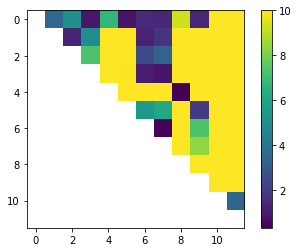

('Active promoter', 'Weak promoter') 3.241717310505784
('Active promoter', 'Strong Tx') 4.846133485313646
('Active promoter', 'Weak Tx1') 0.6786696096067586
('Active promoter', 'Weak Tx2') 6.444989467039166
('Active promoter', 'Weak enhancer') 0.5640413882493625
('Active promoter', 'Poised promoter1') 1.2202949367397424
('Active promoter', 'Poised promoter2') 1.0971286165709828
('Active promoter', 'Tx elongation') 9.04928874519482
('Active promoter', 'Polycomb repressed') 1.0493456528357776
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 1.0329734256557566
('Weak promoter', 'Weak Tx1') 4.739986928335009
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 9.9999999919384
('Weak promoter', 'Poised promoter1') 0.926360513755389
('Weak promoter', 'Poised promoter2') 1.4670049926425346
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 9.999999999999936
('Weak promoter', 'Heteroc

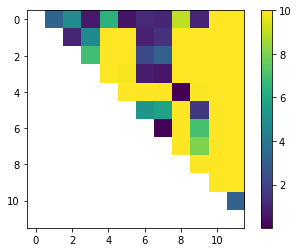

('Active promoter', 'Weak promoter') 0.6119293895441678
('Active promoter', 'Strong Tx') 0.027265519282746738
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.8435989403359836
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('St

('Active promoter', 'Weak promoter') 0.9110542625733473
('Active promoter', 'Strong Tx') 0.3989773289662335
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 1.4872149056900037
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Stro

('Active promoter', 'Weak promoter') 0.6100574168499895
('Active promoter', 'Strong Tx') 0.09797874737064513
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 1.186213962463036
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Stro

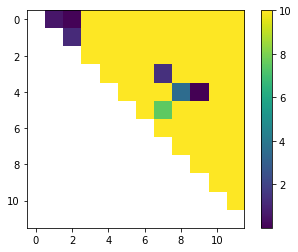

('Active promoter', 'Weak promoter') 2.499283486999859
('Active promoter', 'Strong Tx') 9.999999872280652
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 5.833485095687722
('Active promoter', 'Weak enhancer') 9.99999999522726
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 9.999770827321361
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 2.1967994164114084
('Weak promoter', 'Weak enhancer') 9.999999999950415
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 2.1620990494615984
('Strong T

('Active promoter', 'Weak promoter') 2.2302297719703694
('Active promoter', 'Strong Tx') 9.99999706801258
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 4.728858726199053
('Active promoter', 'Weak enhancer') 9.99999997500783
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 9.999611377616786
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 2.1182054880659966
('Weak promoter', 'Weak enhancer') 9.999999999868136
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 2.2344144086277407
('Strong T

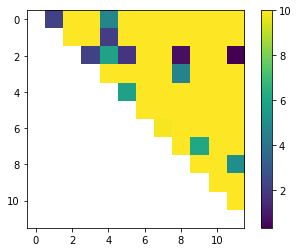

('Active promoter', 'Weak promoter') 1.9292566339398893
('Active promoter', 'Strong Tx') 9.999994139599677
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 4.427944631641878
('Active promoter', 'Weak enhancer') 9.999999950019184
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 9.999223276689987
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 1.8172057039986687
('Weak promoter', 'Weak enhancer') 9.99999999973628
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 1.9333980155400672
('Strong 

('Active promoter', 'Weak promoter') 4.3736919442064055
('Active promoter', 'Strong Tx') 4.085559687039103
('Active promoter', 'Weak Tx1') 0.46876893228780797
('Active promoter', 'Weak Tx2') 9.717730452047714
('Active promoter', 'Weak enhancer') 0.8194457684045593
('Active promoter', 'Poised promoter1') 2.3305512257491245
('Active promoter', 'Poised promoter2') 1.7489902261583112
('Active promoter', 'Tx elongation') 9.991788318059745
('Active promoter', 'Polycomb repressed') 1.1340879897735154
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.07838487262632922
('Weak promoter', 'Weak Tx1') 9.531317075985777
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 0.6636458288863154
('Weak promoter', 'Poised promoter2') 1.6567300076252955
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('W

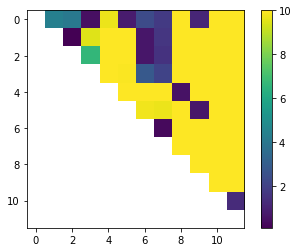

('Active promoter', 'Weak promoter') 4.958061390398866
('Active promoter', 'Strong Tx') 4.339104645202404
('Active promoter', 'Weak Tx1') 0.8226453087296255
('Active promoter', 'Weak Tx2') 8.504268154089187
('Active promoter', 'Weak enhancer') 0.9833295099425008
('Active promoter', 'Poised promoter1') 2.698684505180142
('Active promoter', 'Poised promoter2') 2.223336693327481
('Active promoter', 'Tx elongation') 9.950700501287228
('Active promoter', 'Polycomb repressed') 1.2844649051841301
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.36103303309130375
('Weak promoter', 'Weak Tx1') 8.899724419243821
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 0.9408385982263073
('Weak promoter', 'Poised promoter2') 1.781963837656203
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak p

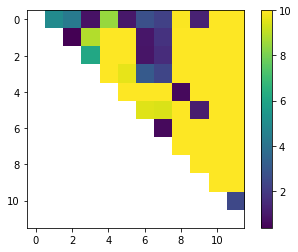

('Active promoter', 'Weak promoter') 4.657122611138244
('Active promoter', 'Strong Tx') 4.038209588396718
('Active promoter', 'Weak Tx1') 0.5216261064821837
('Active promoter', 'Weak Tx2') 8.21038351140294
('Active promoter', 'Weak enhancer') 0.6823056388559808
('Active promoter', 'Poised promoter1') 2.397763152882094
('Active promoter', 'Poised promoter2') 1.9223822214673267
('Active promoter', 'Tx elongation') 9.906433873468147
('Active promoter', 'Polycomb repressed') 0.9834392740363188
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.06001478379471281
('Weak promoter', 'Weak Tx1') 8.616303612531066
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 9.999999999999998
('Weak promoter', 'Poised promoter1') 0.6398315485044103
('Weak promoter', 'Poised promoter2') 1.480961328065215
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 

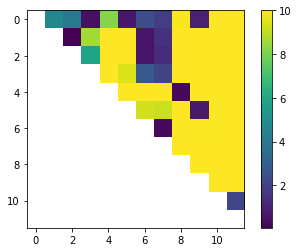

('Active promoter', 'Weak promoter') 0.3757953307420862
('Active promoter', 'Strong Tx') 1.2843380330038245
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 0.7418691552744223
('Active promoter', 'Poised promoter2') 6.7922858010687985
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 4.05295848298342
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 2.686348336476968
('Weak promoter', 'Poised promoter2') 9.980156288298176
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak T

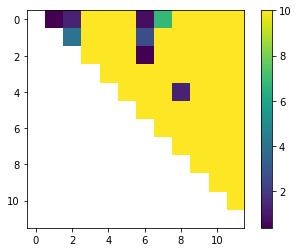

('Active promoter', 'Weak promoter') 0.7680943289638348
('Active promoter', 'Strong Tx') 1.8657980532168366
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 0.9195348588315237
('Active promoter', 'Poised promoter2') 7.488757751304275
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 5.439004734365114
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 2.643494058127269
('Weak promoter', 'Poised promoter2') 9.98719203238978
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx

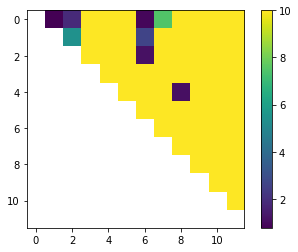

('Active promoter', 'Weak promoter') 0.46709409697387066
('Active promoter', 'Strong Tx') 1.5648511332567054
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 0.6185619420826461
('Active promoter', 'Poised promoter2') 7.1885458048048685
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 5.138041642441923
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 2.342506615233444
('Weak promoter', 'Poised promoter2') 9.97475537018173
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak 

10.0
('Tx elongation', 'Heterochromatin') 10.0
('Tx elongation', 'Quiescence') 10.0
('Polycomb repressed', 'Heterochromatin') 10.0
('Polycomb repressed', 'Quiescence') 10.0
('Heterochromatin', 'Quiescence') 10.0
kruskal


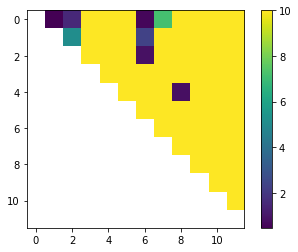

('Active promoter', 'Weak promoter') 0.16601212126400472
('Active promoter', 'Strong Tx') 9.988193835572435
('Active promoter', 'Weak Tx1') 9.999234206042532
('Active promoter', 'Weak Tx2') 1.7848016581093422
('Active promoter', 'Weak enhancer') 4.176961221494741
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 8.343581904416563
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 9.999996876631894
('Weak promoter', 'Strong Tx') 9.999999897282787
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 2.076946831362476
('Weak promoter', 'Weak enhancer') 7.998315421562687
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 9.999999998628194
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0


('Active promoter', 'Weak promoter') 0.3692938381523051
('Active promoter', 'Strong Tx') 9.920455634560227
('Active promoter', 'Weak Tx1') 9.920549178448331
('Active promoter', 'Weak Tx2') 1.3205526130065317
('Active promoter', 'Weak enhancer') 3.6494723718902606
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 6.875063301231283
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 9.999879684426233
('Weak promoter', 'Strong Tx') 9.99999975520484
('Weak promoter', 'Weak Tx1') 9.999999999999998
('Weak promoter', 'Weak Tx2') 1.8280700756717376
('Weak promoter', 'Weak enhancer') 7.711919000825036
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 9.999999918734042
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quies

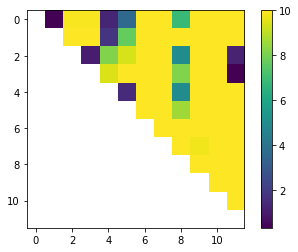

('Active promoter', 'Weak promoter') 0.06828222277129381
('Active promoter', 'Strong Tx') 9.853312472859914
('Active promoter', 'Weak Tx1') 9.853423376875417
('Active promoter', 'Weak Tx2') 1.0195776035889217
('Active promoter', 'Weak enhancer') 3.3484557413528004
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 6.574207220247611
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 9.999759402913181
('Weak promoter', 'Strong Tx') 9.999999510532948
('Weak promoter', 'Weak Tx1') 9.999999999999996
('Weak promoter', 'Weak Tx2') 1.5270677907617984
('Weak promoter', 'Weak enhancer') 7.412019282216678
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 9.999999837471563
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Qui

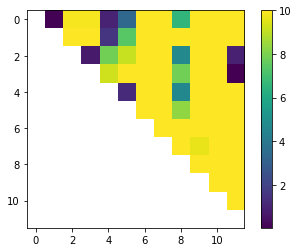

('Active promoter', 'Weak promoter') 9.999999999894447
('Active promoter', 'Strong Tx') 9.999999997714095
('Active promoter', 'Weak Tx1') 0.3692268495616276
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 4.056715469208377
('Active promoter', 'Poised promoter1') 9.999975896966335
('Active promoter', 'Poised promoter2') 9.760927513911682
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 6.718713593622843
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.12121364083674441
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 0.9676095727245145
('Weak promoter', 'Poised promoter2') 4.771483324975697
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx'

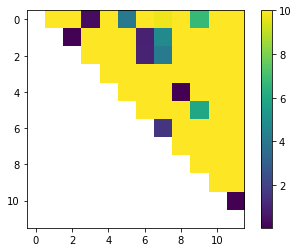

('Active promoter', 'Weak promoter') 9.999999999998844
('Active promoter', 'Strong Tx') 9.999999999806256
('Active promoter', 'Weak Tx1') 0.9022534565678949
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 3.879218157082348
('Active promoter', 'Poised promoter1') 9.999988316451526
('Active promoter', 'Poised promoter2') 9.893362349421832
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 6.885755768215634
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.4992195163053762
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 1.4460013604356792
('Weak promoter', 'Poised promoter2') 5.325482897362812
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx',

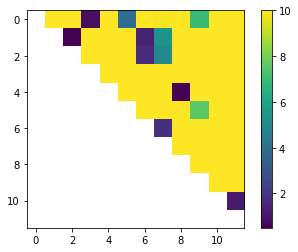

('Active promoter', 'Weak promoter') 9.999999999997687
('Active promoter', 'Strong Tx') 9.999999999612777
('Active promoter', 'Weak Tx1') 0.601234900632071
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 3.578202048144496
('Active promoter', 'Poised promoter1') 9.999976647855648
('Active promoter', 'Poised promoter2') 9.807878813817466
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 6.58490409009779
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.198204124852866
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 1.1450012246902705
('Weak promoter', 'Poised promoter2') 5.024508667495066
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'W

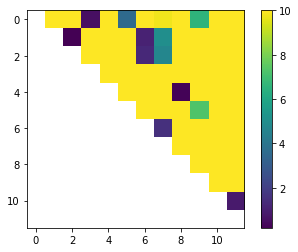

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 2.3888888913086572
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 

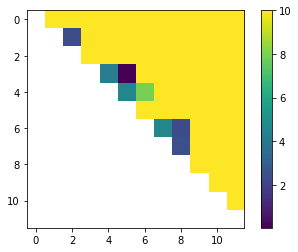

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 2.3440544903081264
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 2.0430624774139887
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 

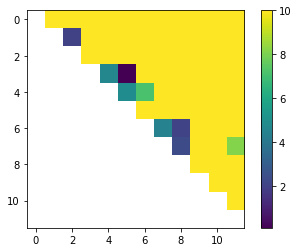

('Active promoter', 'Weak promoter') 9.999999954606867
('Active promoter', 'Strong Tx') 0.5391226361974227
('Active promoter', 'Weak Tx1') 9.999853614714198
('Active promoter', 'Weak Tx2') 9.999999981147708
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 9.999973800424936
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 1.0489776894523188
('Active promoter', 'Heterochromatin') 0.11396028038774374
('Active promoter', 'Quiescence') 9.999684961735051
('Weak promoter', 'Strong Tx') 9.999999999881894
('Weak promoter', 'Weak Tx1') 2.2778505005303753
('Weak promoter', 'Weak Tx2') 0.48624276850761144
('Weak promoter', 'Weak enhancer') 2.0790640610234097
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 7.604704690408345
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak

ttest


('Active promoter', 'Weak promoter') 9.999999998410608
('Active promoter', 'Strong Tx') 0.8291646909594679
('Active promoter', 'Weak Tx1') 9.999848397432979
('Active promoter', 'Weak Tx2') 9.999999999852596
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 9.999992171669712
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 0.9789867679702314
('Active promoter', 'Heterochromatin') 0.8405648216779245
('Active promoter', 'Quiescence') 9.999995452343821
('Weak promoter', 'Strong Tx') 9.999999999995284
('Weak promoter', 'Weak Tx1') 2.7716295586504023
('Weak promoter', 'Weak Tx2') 1.3429786684821754
('Weak promoter', 'Weak enhancer') 2.581048656837529
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 8.145788755530452
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak pr

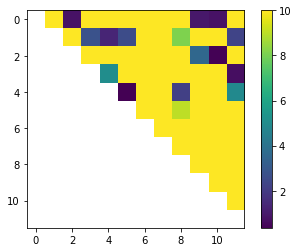

('Active promoter', 'Weak promoter') 9.999999996822533
('Active promoter', 'Strong Tx') 0.5281853652775367
('Active promoter', 'Weak Tx1') 9.99969688471746
('Active promoter', 'Weak Tx2') 9.999999999705357
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 9.999984351152957
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 0.677960466384245
('Active promoter', 'Heterochromatin') 0.5395408708174156
('Active promoter', 'Quiescence') 9.999990904764672
('Weak promoter', 'Strong Tx') 9.999999999990571
('Weak promoter', 'Weak Tx1') 2.470610575784126
('Weak promoter', 'Weak Tx2') 1.0419717210080988
('Weak promoter', 'Weak enhancer') 2.2800242646580866
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 7.847813405211208
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak prom

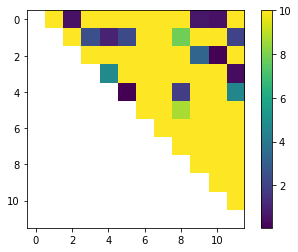

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 9.999999999999972
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 2.481643354052061
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised 

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 9.999999999997408
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 3.250785594337707
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised 

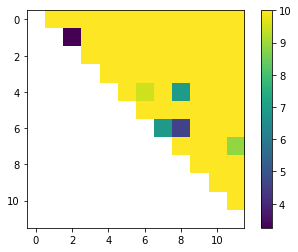

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 9.99999999999482
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 2.9498014185331076
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised 

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 2.7202898328616354
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 3.648418347115389
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 1

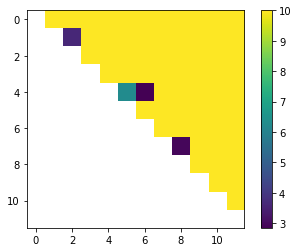

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 3.347437300291347
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 1

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.22193862122595914
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1')

 10.0
('Weak Tx2', 'Weak enhancer') 9.948630368854392
('Weak Tx2', 'Poised promoter1') 9.972316442883791
('Weak Tx2', 'Poised promoter2') 0.44738468925536035
('Weak Tx2', 'Tx elongation') 10.0
('Weak Tx2', 'Polycomb repressed') 10.0
('Weak Tx2', 'Heterochromatin') 10.0
('Weak Tx2', 'Quiescence') 10.0
('Weak enhancer', 'Poised promoter1') 1.3885301458551675
('Weak enhancer', 'Poised promoter2') 10.0
('Weak enhancer', 'Tx elongation') 10.0
('Weak enhancer', 'Polycomb repressed') 10.0
('Weak enhancer', 'Heterochromatin') 10.0
('Weak enhancer', 'Quiescence') 10.0
('Poised promoter1', 'Poised promoter2') 9.999999999997485
('Poised promoter1', 'Tx elongation') 10.0
('Poised promoter1', 'Polycomb repressed') 10.0
('Poised promoter1', 'Heterochromatin') 10.0
('Poised promoter1', 'Quiescence') 10.0
('Poised promoter2', 'Tx elongation') 10.0
('Poised promoter2', 'Polycomb repressed') 10.0
('Poised promoter2', 'Heterochromatin') 10.0
('Poised promoter2', 'Quiescence') 10.0
('Tx elongation', 'Poly

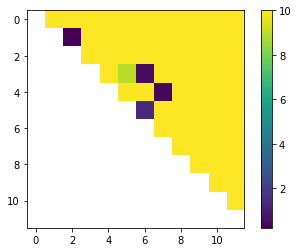

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.31381908772236755
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1')

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 9.999999999999998
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.012799761251370018
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Pois

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 1.8085692518468521
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 

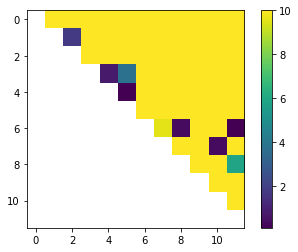

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 2.425128034946218
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 1

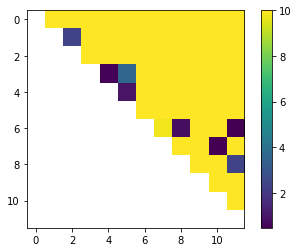

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 2.12413677619566
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 10

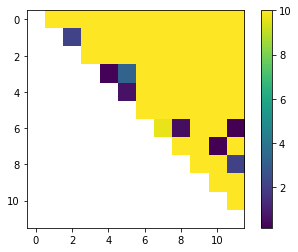

('Active promoter', 'Weak promoter') 9.99999997879699
('Active promoter', 'Strong Tx') 9.999990534112124
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.0706107755603677
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong 

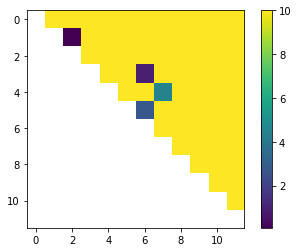

('Active promoter', 'Weak promoter') 9.999999992492235
('Active promoter', 'Strong Tx') 9.999926582236707
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.5920182443976828
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong

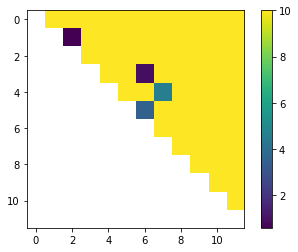

('Active promoter', 'Weak promoter') 9.999999984990565
('Active promoter', 'Strong Tx') 9.999853261474724
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.29100458353890424
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Stron

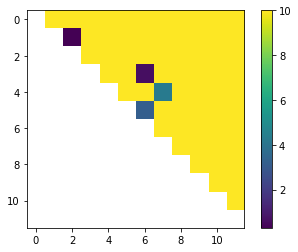

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 5.7804028777757885
('Active promoter', 'Weak Tx2') 9.999999999999993
('Active promoter', 'Weak enhancer') 1.0701413137649458
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 9.637316618757813
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 9.999842495679188
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'We

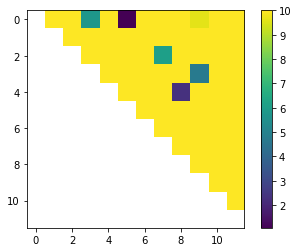

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 6.672273324802376
('Active promoter', 'Weak Tx2') 9.999999999999996
('Active promoter', 'Weak enhancer') 0.7561633827135518
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 9.999985261190771
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 9.999991963509538
('Weak promoter', 'Weak Tx1') 9.999999999999998
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Str

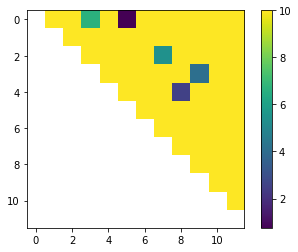

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 6.371381866996209
('Active promoter', 'Weak Tx2') 9.999999999999995
('Active promoter', 'Weak enhancer') 0.4551385779822365
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 9.999970524026818
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 9.999983931008122
('Weak promoter', 'Weak Tx1') 9.999999999999998
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Str

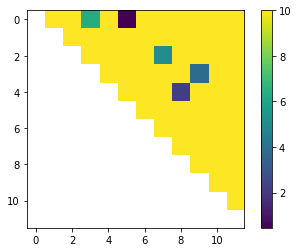

('Active promoter', 'Weak promoter') 9.99999999974148
('Active promoter', 'Strong Tx') 9.99999235596856
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.5275712949478938
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong T

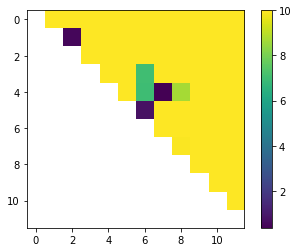

('Active promoter', 'Weak promoter') 9.999999999499204
('Active promoter', 'Strong Tx') 9.999961272994272
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 1.0520782438731846
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong


('Poised promoter1', 'Quiescence') 10.0
('Poised promoter2', 'Tx elongation') 9.992149455788487
('Poised promoter2', 'Polycomb repressed') 10.0
('Poised promoter2', 'Heterochromatin') 10.0
('Poised promoter2', 'Quiescence') 10.0
('Tx elongation', 'Polycomb repressed') 10.0
('Tx elongation', 'Heterochromatin') 10.0
('Tx elongation', 'Quiescence') 10.0
('Polycomb repressed', 'Heterochromatin') 10.0
('Polycomb repressed', 'Quiescence') 10.0
('Heterochromatin', 'Quiescence') 10.0
mannwhitneyu


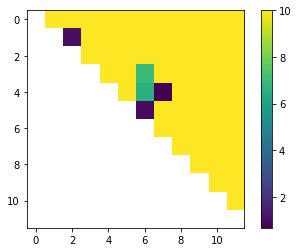

('Active promoter', 'Weak promoter') 9.999999998998831
('Active promoter', 'Strong Tx') 9.999922594538287
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.7510717784912225
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong

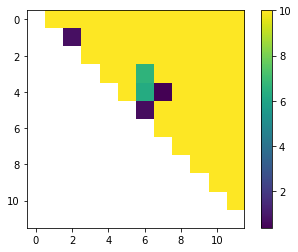

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 3.001570307867022
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 1

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 2.445901911332533
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 1

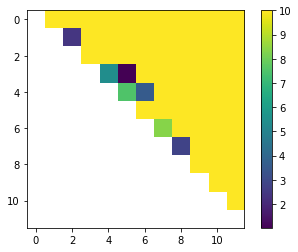

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 2.1449108438636597
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 

('Active promoter', 'Weak promoter') 9.999999999999908
('Active promoter', 'Strong Tx') 9.999999988770517
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.5699945603494921
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong

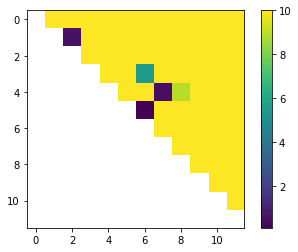

('Active promoter', 'Weak promoter') 9.999999999999867
('Active promoter', 'Strong Tx') 9.999999972856344
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.9036652407800665
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong

('Active promoter', 'Weak promoter') 9.999999999999734
('Active promoter', 'Strong Tx') 9.999999945747833
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.6026566499036121
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong

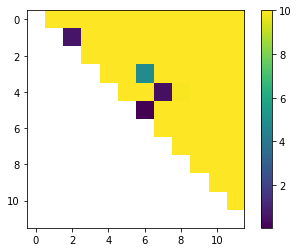

('Active promoter', 'Weak promoter') 9.999999999998968
('Active promoter', 'Strong Tx') 9.999996731372851
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.9460782220980959
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong

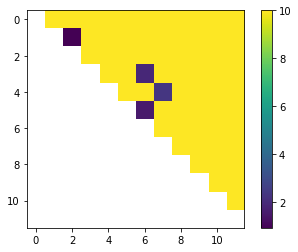

('Active promoter', 'Weak promoter') 9.999999999995875
('Active promoter', 'Strong Tx') 9.999994563688
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 1.3256347157603863
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx

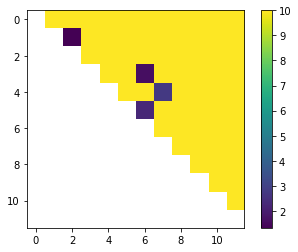

('Active promoter', 'Weak promoter') 9.999999999991754
('Active promoter', 'Strong Tx') 9.999989133973727
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 1.0246318260688498
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong

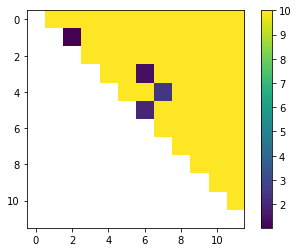

('Active promoter', 'Weak promoter') 1.0289902476641217
('Active promoter', 'Strong Tx') 4.265851692744065
('Active promoter', 'Weak Tx1') 7.808281276234626
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 9.999999999999948
('Active promoter', 'Poised promoter1') 9.99641439461609
('Active promoter', 'Poised promoter2') 1.4118449786542089
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 9.999999999999995
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 3.6529152925753525
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 9.999999954266714
('Weak promoter', 'Poised promoter2') 0.31935220132389885
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx'

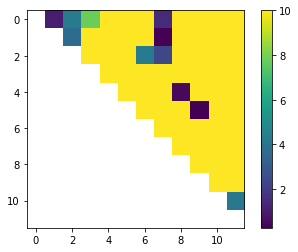

('Active promoter', 'Weak promoter') 1.1102743092897474
('Active promoter', 'Strong Tx') 4.648738631617846
('Active promoter', 'Weak Tx1') 7.8938239832232036
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 9.999999999999977
('Active promoter', 'Poised promoter1') 9.984242002351044
('Active promoter', 'Poised promoter2') 1.495092528565417
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 4.843103285841524
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 9.999996579279932
('Weak promoter', 'Poised promoter2') 0.6279637025818534
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 

('Active promoter', 'Weak promoter') 0.809281794194321
('Active promoter', 'Strong Tx') 4.347849293555548
('Active promoter', 'Weak Tx1') 7.594537573403077
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 9.999999999999956
('Active promoter', 'Poised promoter1') 9.969052287467491
('Active promoter', 'Poised promoter2') 1.1941222904133342
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 9.999999999999998
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 4.542131979989541
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 9.99999316031789
('Weak promoter', 'Poised promoter2') 0.32694812524134637
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 

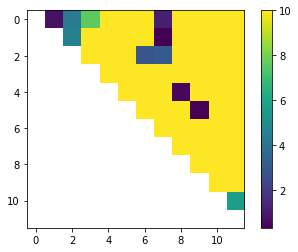

('Active promoter', 'Weak promoter') 0.9037952789754807
('Active promoter', 'Strong Tx') 9.999905147512331
('Active promoter', 'Weak Tx1') 9.999999998927828
('Active promoter', 'Weak Tx2') 2.166084018948789
('Active promoter', 'Weak enhancer') 7.87134269475966
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 9.992162088990813
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 9.997739536752775
('Weak promoter', 'Strong Tx') 9.999997899820784
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 1.0431108115201393
('Weak promoter', 'Weak enhancer') 9.842643137521446
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 9.999999999353154
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 9.99999

('Active promoter', 'Weak promoter') 0.8827270882526779
('Active promoter', 'Strong Tx') 9.998950330091638
('Active promoter', 'Weak Tx1') 9.999999783345716
('Active promoter', 'Weak Tx2') 1.4905527414270878
('Active promoter', 'Weak enhancer') 6.996360940367619
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 9.601512518575083
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 9.938757779514784
('Weak promoter', 'Strong Tx') 9.999997675503591
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 0.9674911461381618
('Weak promoter', 'Weak enhancer') 9.838373683118958
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 9.999999977454893
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 9.999

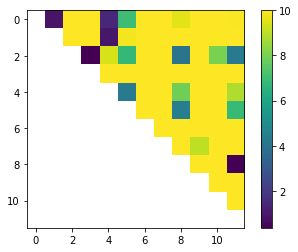

('Active promoter', 'Weak promoter') 0.5817295921481236
('Active promoter', 'Strong Tx') 9.997904342165539
('Active promoter', 'Weak Tx1') 9.999999566749954
('Active promoter', 'Weak Tx2') 1.1895818975030228
('Active promoter', 'Weak enhancer') 6.695565298965134
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 9.397265793595608
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 9.885094252536168
('Weak promoter', 'Strong Tx') 9.999995352151513
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 0.6664799949557689
('Weak promoter', 'Weak enhancer') 9.720857883692775
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 9.999999954910763
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 9.999


('Weak Tx2', 'Polycomb repressed') 10.0
('Weak Tx2', 'Heterochromatin') 10.0
('Weak Tx2', 'Quiescence') 8.55583297690741
('Weak enhancer', 'Poised promoter1') 10.0
('Weak enhancer', 'Poised promoter2') 10.0
('Weak enhancer', 'Tx elongation') 4.196769869228215
('Weak enhancer', 'Polycomb repressed') 10.0
('Weak enhancer', 'Heterochromatin') 10.0
('Weak enhancer', 'Quiescence') 6.570471568308561
('Poised promoter1', 'Poised promoter2') 9.999999999908246
('Poised promoter1', 'Tx elongation') 10.0
('Poised promoter1', 'Polycomb repressed') 10.0
('Poised promoter1', 'Heterochromatin') 10.0
('Poised promoter1', 'Quiescence') 10.0
('Poised promoter2', 'Tx elongation') 10.0
('Poised promoter2', 'Polycomb repressed') 8.785903118048292
('Poised promoter2', 'Heterochromatin') 10.0
('Poised promoter2', 'Quiescence') 10.0
('Tx elongation', 'Polycomb repressed') 10.0
('Tx elongation', 'Heterochromatin') 10.0
('Tx elongation', 'Quiescence') 0.1006068580019886
('Polycomb repressed', 'Heterochromatin'

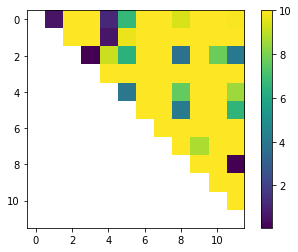

('Active promoter', 'Weak promoter') 9.999999999998098
('Active promoter', 'Strong Tx') 9.999999999872903
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.13611207038641063
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Stron

('Active promoter', 'Weak promoter') 9.999999999991612
('Active promoter', 'Strong Tx') 9.999999959902317
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.5056579618160761
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong

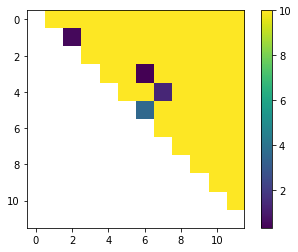

('Active promoter', 'Weak promoter') 9.999999999983231
('Active promoter', 'Strong Tx') 9.999999919856284
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.204642694714206
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong 

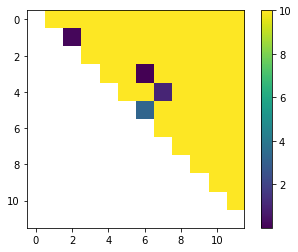

('Active promoter', 'Weak promoter') 0.10393139647458878
('Active promoter', 'Strong Tx') 0.628411219357163
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 9.999999988035551
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.7832750643096213
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer'

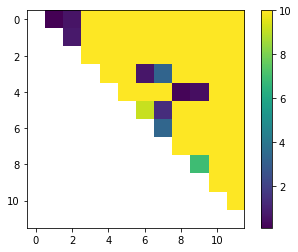

('Active promoter', 'Weak promoter') 0.4506113063989257
('Active promoter', 'Strong Tx') 0.9656855647906213
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 9.999999825236099
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.9854647112105468
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer'

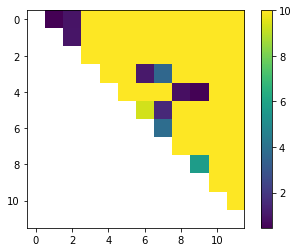

('Active promoter', 'Weak promoter') 0.14960233158121186
('Active promoter', 'Strong Tx') 0.6647113245783967
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 9.999999650705178
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.6844573106862979
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer


('Strong Tx', 'Polycomb repressed') 10.0
('Strong Tx', 'Heterochromatin') 10.0
('Strong Tx', 'Quiescence') 10.0
('Weak Tx1', 'Weak Tx2') 10.0
('Weak Tx1', 'Weak enhancer') 9.999999999999924
('Weak Tx1', 'Poised promoter1') 0.7959450524907147
('Weak Tx1', 'Poised promoter2') 3.351312331525985
('Weak Tx1', 'Tx elongation') 10.0
('Weak Tx1', 'Polycomb repressed') 10.0
('Weak Tx1', 'Heterochromatin') 10.0
('Weak Tx1', 'Quiescence') 10.0
('Weak Tx2', 'Weak enhancer') 10.0
('Weak Tx2', 'Poised promoter1') 10.0
('Weak Tx2', 'Poised promoter2') 10.0
('Weak Tx2', 'Tx elongation') 0.5301057858570657
('Weak Tx2', 'Polycomb repressed') 0.19125920717331235
('Weak Tx2', 'Heterochromatin') 10.0
('Weak Tx2', 'Quiescence') 10.0
('Weak enhancer', 'Poised promoter1') 9.117334909891909
('Weak enhancer', 'Poised promoter2') 1.245968512889691
('Weak enhancer', 'Tx elongation') 10.0
('Weak enhancer', 'Polycomb repressed') 10.0
('Weak enhancer', 'Heterochromatin') 10.0
('Weak enhancer', 'Quiescence') 10.0
('

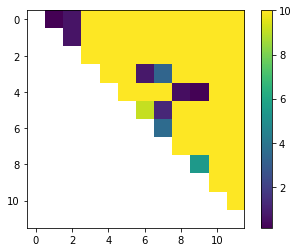

('Active promoter', 'Weak promoter') 9.999994728297054
('Active promoter', 'Strong Tx') 9.999999485050937
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.529664827030262
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong 

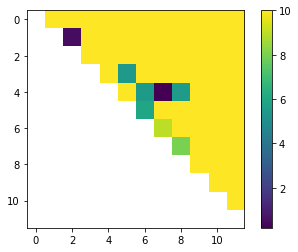

('Active promoter', 'Weak promoter') 9.99999938389021
('Active promoter', 'Strong Tx') 9.999999974023805
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.77577067724449
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx

('Active promoter', 'Weak promoter') 9.999998768252572
('Active promoter', 'Strong Tx') 9.999999948081262
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.47476012063471407
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Stron

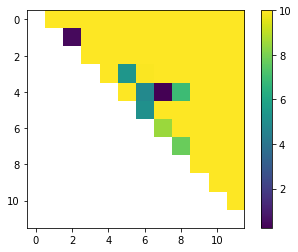

('Active promoter', 'Weak promoter') 2.0171403425370547
('Active promoter', 'Strong Tx') 5.356339932828203
('Active promoter', 'Weak Tx1') 0.028712220215991364
('Active promoter', 'Weak Tx2') 4.892434072180462
('Active promoter', 'Weak enhancer') 3.5545548788238657
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 7.867366221386762
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 3.4086989202902616
('Active promoter', 'Quiescence') 5.561730215305743
('Weak promoter', 'Strong Tx') 9.999999999612264
('Weak promoter', 'Weak Tx1') 5.494584752785061
('Weak promoter', 'Weak Tx2') 2.111963657885269
('Weak promoter', 'Weak enhancer') 0.7075868820199113
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 6.118439855827939
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak 

('Active promoter', 'Weak promoter') 2.579503655923532
('Active promoter', 'Strong Tx') 5.575781636523467
('Active promoter', 'Weak Tx1') 0.30670210043924984
('Active promoter', 'Weak Tx2') 6.29241327371687
('Active promoter', 'Weak enhancer') 4.665666393951955
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 9.554615967722706
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 2.6283860129802075
('Active promoter', 'Quiescence') 7.793042190493223
('Weak promoter', 'Strong Tx') 9.999999999966597
('Weak promoter', 'Weak Tx1') 6.08157786525627
('Weak promoter', 'Weak Tx2') 3.1155291180503166
('Weak promoter', 'Weak enhancer') 1.1240352995169698
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 7.10348132544312
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 9.999999999999993

('Poised promoter2', 'Heterochromatin') 10.0
('Poised promoter2', 'Quiescence') 10.0
('Tx elongation', 'Polycomb repressed') 10.0
('Tx elongation', 'Heterochromatin') 10.0
('Tx elongation', 'Quiescence') 7.977018323386511
('Polycomb repressed', 'Heterochromatin') 10.0
('Polycomb repressed', 'Quiescence') 10.0
('Heterochromatin', 'Quiescence') 10.0
mannwhitneyu


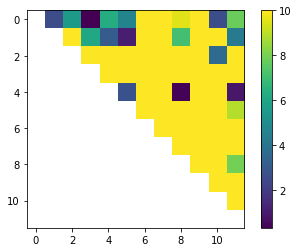

('Active promoter', 'Weak promoter') 2.278535504480543
('Active promoter', 'Strong Tx') 5.274914173534385
('Active promoter', 'Weak Tx1') 0.005677723748757179
('Active promoter', 'Weak Tx2') 5.991559989555915
('Active promoter', 'Weak enhancer') 4.364652614285673
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 9.339413170948495
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 2.327368015150123
('Active promoter', 'Quiescence') 7.49336361349129
('Weak promoter', 'Strong Tx') 9.999999999933216
('Weak promoter', 'Weak Tx1') 5.7805911073901655
('Weak promoter', 'Weak Tx2') 2.8145368554108874
('Weak promoter', 'Weak enhancer') 0.82300872010866
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 6.80273286358822
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 9.999999999999986

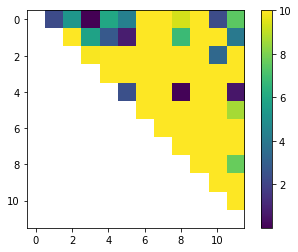

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.2379260072553919
('Weak promoter', 'Weak Tx1') 9.999928262418853
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 9.951129172111939
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 9.99999999902

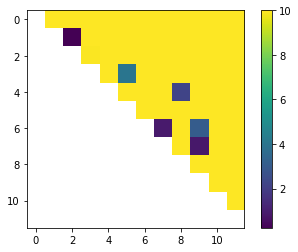

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 9.999999999999956
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.6221332597221148
('Weak promoter', 'Weak Tx1') 9.99897304603267
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 9.879943344843579
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 9

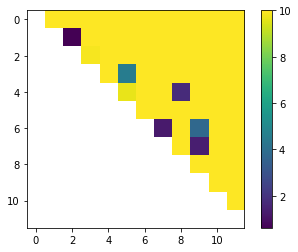

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 9.99999999999991
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.32112013439811793
('Weak promoter', 'Weak Tx1') 9.997948633334646
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 9.78600157411037
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 9

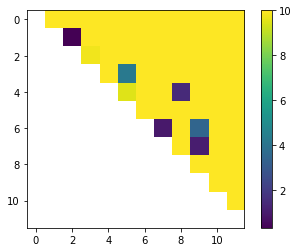

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 2.7517549458468933
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 9.999999999999998
('Active promoter', 'Poised promoter2') 1.4672564030290278
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 9.999999999999996
('Weak promoter', 'Weak Tx1') 6.311297621678334
('Weak promoter', 'Weak Tx2') 9.999999999999998
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 1.2720990252650044
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak T

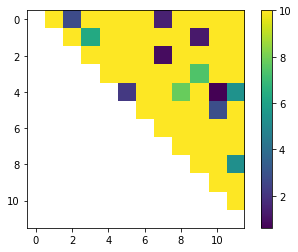

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 3.3865360497230723
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 2.594958315269225
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 10.0
('Weak promoter', 'Weak Tx1') 4.96525842675459
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 1.5063886655768386
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 3.085623182097704
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 9.999999999999998
('Active promoter', 'Poised promoter2') 2.294010896290326
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 10.0
('Weak promoter', 'Weak Tx1') 4.6642456835229895
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 1.205361185123999
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Wea

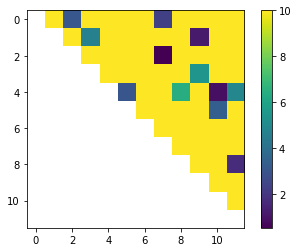

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.8921686305300552
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 

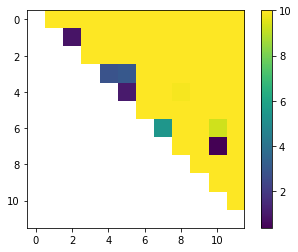

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 1.6295811879606008
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 

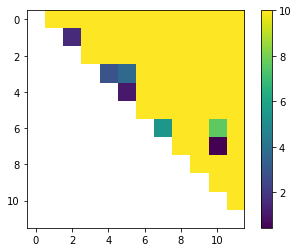

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 1.3285818763176065
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 

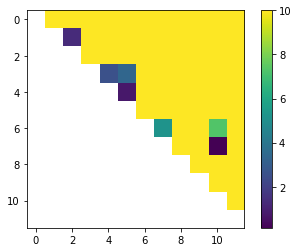

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.30262021094433883
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1')

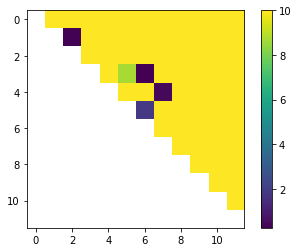

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 9.999999999999986
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.43226282106051395
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poise

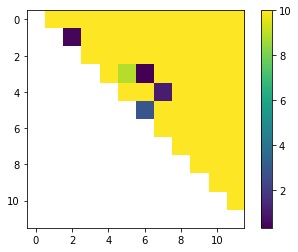

('Active promoter', 'Weak promoter') 9.999999999999998
('Active promoter', 'Strong Tx') 9.999999999999973
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.13124609313344326
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Stron

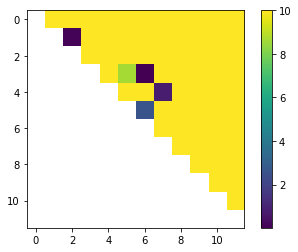

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 1.2623386668538286
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 2.350354499864478
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 1

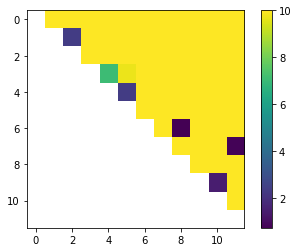

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 2.049362545927965
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 1

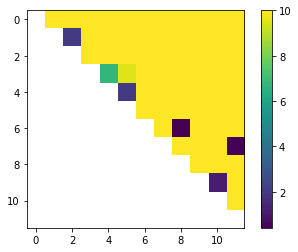

('Active promoter', 'Weak promoter') 0.4703587495026923
('Active promoter', 'Strong Tx') 0.46340335981283015
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 9.999999999773648
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 2.15888177630487
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer')

 10.0
('Weak enhancer', 'Polycomb repressed') 10.0
('Weak enhancer', 'Heterochromatin') 10.0
('Weak enhancer', 'Quiescence') 10.0
('Poised promoter1', 'Poised promoter2') 9.999980848798872
('Poised promoter1', 'Tx elongation') 10.0
('Poised promoter1', 'Polycomb repressed') 10.0
('Poised promoter1', 'Heterochromatin') 10.0
('Poised promoter1', 'Quiescence') 10.0
('Poised promoter2', 'Tx elongation') 10.0
('Poised promoter2', 'Polycomb repressed') 10.0
('Poised promoter2', 'Heterochromatin') 10.0
('Poised promoter2', 'Quiescence') 10.0
('Tx elongation', 'Polycomb repressed') 10.0
('Tx elongation', 'Heterochromatin') 10.0
('Tx elongation', 'Quiescence') 10.0
('Polycomb repressed', 'Heterochromatin') 10.0
('Polycomb repressed', 'Quiescence') 10.0
('Heterochromatin', 'Quiescence') 10.0
ttest


('Active promoter', 'Weak promoter') 0.7137436018418656
('Active promoter', 'Strong Tx') 1.0564053246132805
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 9.999999998984702
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 3.017055791618963
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer')

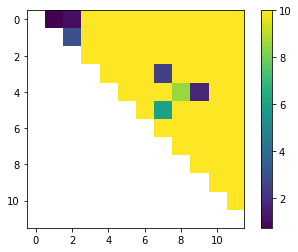

('Active promoter', 'Weak promoter') 0.41274200761221624
('Active promoter', 'Strong Tx') 0.7554342791767907
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 9.999999997970852
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 2.716069705879788
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer'

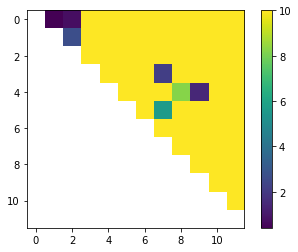

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 2.4411926375452775
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 1.944580183258752
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 1

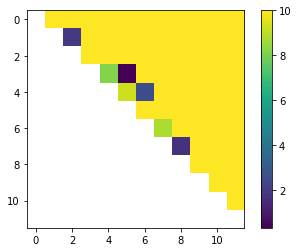

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 1.6435842509311938
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 

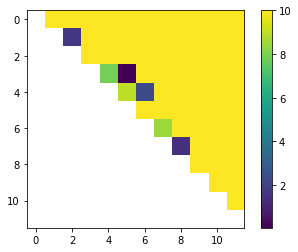

('Active promoter', 'Weak promoter') 0.05273225112152057
('Active promoter', 'Strong Tx') 0.7495870190434505
('Active promoter', 'Weak Tx1') 9.999999999999979
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 9.99950084503137
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 1.5344720140642918
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 9.999999999999995
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('S

('Active promoter', 'Weak promoter') 0.3100507867127879
('Active promoter', 'Strong Tx') 1.2196136935305526
('Active promoter', 'Weak Tx1') 9.999999999999998
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 9.998400612268135
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 2.0057737254113586
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 9.999999999999998
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('S

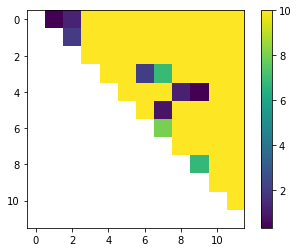

('Active promoter', 'Weak promoter') 0.009037093912805822
('Active promoter', 'Strong Tx') 0.9186480858342131
('Active promoter', 'Weak Tx1') 9.999999999999995
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 9.99680892667268
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 1.7047784176907108
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 9.999999999999996
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('

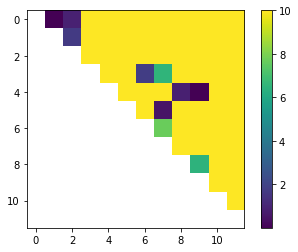

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.23100429357174618
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1')

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 9.999999999999924
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.5276775484417843
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 9.999999999999847
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.22666270158869412
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poise

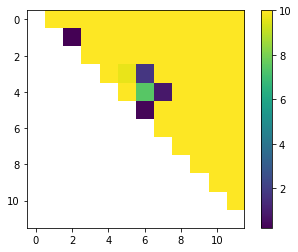

('Active promoter', 'Weak promoter') 3.7764800901932083
('Active promoter', 'Strong Tx') 5.816200848581461
('Active promoter', 'Weak Tx1') 0.4728696564482369
('Active promoter', 'Weak Tx2') 9.999999999999863
('Active promoter', 'Weak enhancer') 4.346143392420319
('Active promoter', 'Poised promoter1') 9.997348955780664
('Active promoter', 'Poised promoter2') 7.099912696211196
('Active promoter', 'Tx elongation') 9.999999999999902
('Active promoter', 'Polycomb repressed') 3.139837970264318
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 1.3367211170793376
('Weak promoter', 'Weak Tx1') 9.999999999856062
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 7.743717704184856
('Weak promoter', 'Poised promoter2') 2.259798057177843
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak prom

('Active promoter', 'Weak promoter') 4.2849029886091365
('Active promoter', 'Strong Tx') 6.344107683014012
('Active promoter', 'Weak Tx1') 0.587379673320031
('Active promoter', 'Weak Tx2') 9.999999999679774
('Active promoter', 'Weak enhancer') 3.8331065104696838
('Active promoter', 'Poised promoter1') 9.998087723379998
('Active promoter', 'Poised promoter2') 7.000259555404025
('Active promoter', 'Tx elongation') 9.99999999990644
('Active promoter', 'Polycomb repressed') 2.766301922156488
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 1.7740691834783653
('Weak promoter', 'Weak Tx1') 9.999999963483743
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 7.490796317106189
('Weak promoter', 'Poised promoter2') 2.075149583843945
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promo

('Active promoter', 'Weak promoter') 3.983955745925023
('Active promoter', 'Strong Tx') 6.043291230530957
('Active promoter', 'Weak Tx1') 0.2863583716173159
('Active promoter', 'Weak Tx2') 9.999999999359906
('Active promoter', 'Weak enhancer') 3.5320902937085803
('Active promoter', 'Poised promoter1') 9.99618601275174
('Active promoter', 'Poised promoter2') 6.69959013396827
('Active promoter', 'Tx elongation') 9.999999999812887
('Active promoter', 'Polycomb repressed') 2.4652787944818075
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 1.4730714585212517
('Weak promoter', 'Weak Tx1') 9.999999926972446
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 7.190514789393652
('Weak promoter', 'Poised promoter2') 1.774149647994247
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promo

('Active promoter', 'Weak promoter') 1.4982153182671212
('Active promoter', 'Strong Tx') 9.999998915348407
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 6.761046516502305
('Active promoter', 'Weak enhancer') 9.999999476293949
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 9.999997633255981
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 4.686587277617487
('Weak promoter', 'Weak enhancer') 9.999999999999622
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 1.2081493647141779
('Strong 

('Active promoter', 'Weak promoter') 1.4261850816335595
('Active promoter', 'Strong Tx') 9.999984926552182
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 5.3421272644528255
('Active promoter', 'Weak enhancer') 9.999995575457467
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 9.999996087997737
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 4.201394238902997
('Weak promoter', 'Weak enhancer') 9.99999999999846
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 1.4432449224199677
('Strong 

('Active promoter', 'Weak promoter') 1.1251987372796322
('Active promoter', 'Strong Tx') 9.99996987144816
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 5.041224732297808
('Active promoter', 'Weak enhancer') 9.999991151539493
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 9.999992177920804
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 3.900409177578853
('Weak promoter', 'Weak enhancer') 9.999999999996922
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 1.142225431666787
('Strong Tx

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 10.0
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.05806401188161393
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1')

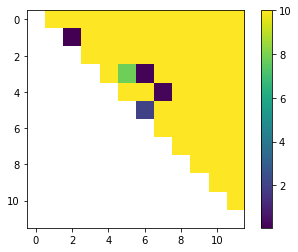

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 9.999999999998048
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.5388271743497693
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised

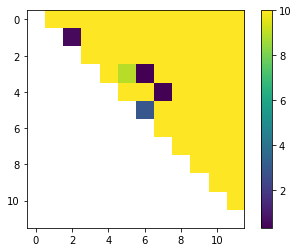

('Active promoter', 'Weak promoter') 10.0
('Active promoter', 'Strong Tx') 9.999999999996097
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.2378125373328581
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised

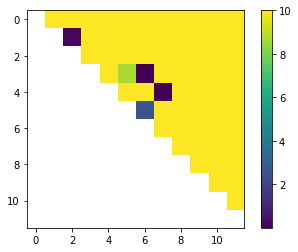

('Active promoter', 'Weak promoter') 0.8871356462277009
('Active promoter', 'Strong Tx') 1.3765837699810861
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.4322961322767391
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Stro

('Active promoter', 'Weak promoter') 1.7289964748085933
('Active promoter', 'Strong Tx') 2.2426025961860754
('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.6465812687150707
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Stro

('Active promoter', 'Weak promoter') 1.4280154504264462
('Active promoter', 'Strong Tx') 1.941665107715026


('Active promoter', 'Weak Tx1') 10.0
('Active promoter', 'Weak Tx2') 10.0
('Active promoter', 'Weak enhancer') 10.0
('Active promoter', 'Poised promoter1') 10.0
('Active promoter', 'Poised promoter2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Polycomb repressed') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Weak promoter', 'Strong Tx') 0.3455685698629574
('Weak promoter', 'Weak Tx1') 10.0
('Weak promoter', 'Weak Tx2') 10.0
('Weak promoter', 'Weak enhancer') 10.0
('Weak promoter', 'Poised promoter1') 10.0
('Weak promoter', 'Poised promoter2') 10.0
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Polycomb repressed') 10.0
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence') 10.0
('Strong Tx', 'Weak Tx1') 10.0
('Strong Tx', 'Weak Tx2') 10.0
('Strong Tx', 'Weak enhancer') 10.0
('Strong Tx', 'Poised promoter1') 10.0
('Strong Tx', 'Poised promoter2') 10.0
('Strong Tx', 'Tx elongation') 10.0


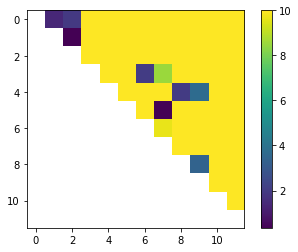

In [25]:
for dkey in dkey_testing_pair_pvalue:
    for testing in testings:
        pair_pvalue = dkey_testing_pair_pvalue[dkey][testing]
        cell = dkey[1]

        if cell == 'H1':
            states = H1_states
        elif cell == 'GM':
            states = GM_states
        elif cell == 'mCD8T':
            states = mCD8T_states

        img = []
        for i in range(len(states)):
            row = []
            for j in range(len(states)):
                try:
                    pair = (states[i], states[j])
                    pvalue = pair_pvalue[pair] + 10**-10
                    logpvalue = -np.log10(pvalue)
                    print pair, logpvalue
                except:
                    logpvalue = np.nan
                row.append(logpvalue)
            img.append(row)

        print testing

        fig = plt.figure()
        plt.imshow(img)
        plt.colorbar()
        plt.show()
        plt.close()
        